In [725]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.model_selection as model_selection

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import tree, ensemble, neural_network, linear_model
from sklearn import metrics

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

from pandas import get_dummies
from scipy.stats import spearmanr

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import Lasso





In [726]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

#### if-setninger for å sjekke ulike metoder om det har innvirkning

In [727]:
#Optimalisering
behold_sykdomskategori=True

#Variabelutvinning
binære_variabler=False
if_clip_5=False
merge_apache_fysiologisk_score=True
merge_overlevelsesestimater=False
gjennomsnittlig_opphold_sykdom=False
merge_fysiologisk_komorbiditeter=True
merge_diabetes_alder=False
merge_nyrefunksjon=True
merge_hjertefunksjon=True
merge_lungefunksjon=False
merge_cancer=True

map_lungefunksjon=False
sykdomkategori_gjennomsnitt=False
vekt_sykdommer=False

fjerne_ekstreme=False
#NaN verdier
fill_in_mean=False
fill_in_knn=True
run_grid_search_forAll=False


#ulike modeller
gradientBoosting_first=True
mlp_first=False
extraTrees_first=True
RandomForest_log=False
Lasso_first=False

extraTrees_second=True
gradientBoosting_second=True


## 1.1 Innlasting av data. 

In [728]:
df_hospital=pd.read_csv('raw_data/hospital.csv')

In [729]:
df_demographic=pd.read_csv('raw_data/demographic.csv')

In [730]:
df_physiological=pd.read_table('raw_data/physiological.txt')

In [731]:
json_df=pd.read_json('raw_data/severity.json')
df_severity = json_df.iloc[:, 0:-1].explode(list(json_df.columns[2:-1])) 
df_severity.reset_index(drop=True, inplace=True)

#### 1.2 Slår sammen tabellene.

In [732]:
df=df_demographic.merge(df_hospital,on='pasient_id',how='outer')\
    .merge(df_physiological,on='pasient_id',how='outer')\
    .merge(df_severity,on='pasient_id',how='outer')

#### 1.2.1 Fjerner duplikater, negativ oppholdslengde. 

In [733]:
df = df.drop_duplicates(subset=['pasient_id']).reset_index(drop=True)
df.set_index('pasient_id', inplace=True)
df = df.loc[df['oppholdslengde'] >= 0].reset_index(drop=True)

#### 1.3 Deler inn i train/validering/test

In [734]:
X = df.drop('oppholdslengde', axis=1)
y = df['oppholdslengde']

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df


,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,oppholdslengde
6964,74.12500,male,12.0,under $11k,white,0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.500000,0.899902,139.0,7.279297,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,COPD,3,0.0,None,0.0,21.097656,17.0,0.73291,0.580933,0,0,no,0.9,0.9,None,5
5117,65.26495,male,12.0,$11-$25k,white,1,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.199951,1.500000,131.0,7.349609,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,5,44.0,None,0.0,46.898438,71.0,0.046997,0.004999,0,0,no,0.1,0.001,None,5
7258,71.98395,male,12.0,NaN,white,0,115.0,10.500000,74.0,22.0,38.09375,112.5000,NaN,NaN,1.699951,137.0,7.429688,115.0,17.0,2095.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,3,0.0,None,0.0,20.398438,26.0,0.741943,0.661987,1,0,yes,0.9,0.9,None,45
3680,52.26599,male,20.0,>$50k,asian,0,77.0,10.398438,60.0,20.0,35.59375,NaN,NaN,NaN,1.699951,135.0,NaN,125.0,33.0,1150.0,ChE,Cancer,0,Colon Cancer,1,0.0,None,0.0,37.195312,22.0,0.404968,0.106995,0,0,metastatic,None,None,None,19
7571,69.77100,male,12.0,>$50k,white,0,57.0,16.898438,165.0,40.0,38.19531,280.7500,NaN,NaN,1.299805,138.0,7.369141,274.0,32.0,1250.0,ChE,Cancer,0,Lung Cancer,1,0.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0,0,metastatic,None,None,None,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,58.71597,male,9.0,under $11k,white,0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,0.500000,1.199951,137.0,7.359375,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,7,0.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0,0,no,0.8,0.7,None,7
5390,81.90594,female,NaN,under $11k,white,0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.299805,1.199951,134.0,7.489258,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,3,0.0,None,5.0,13.298828,29.0,0.852905,0.756958,0,0,yes,0.9,0.9,None,33
860,60.37000,female,12.0,>$50k,white,0,73.0,10.000000,80.0,20.0,38.50000,NaN,NaN,0.399963,0.699951,136.0,NaN,99.0,6.0,3550.0,ChE,Cancer,1,Colon Cancer,1,0.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0,0,metastatic,0.8,0.5,None,6
7603,80.05499,male,8.0,$11-$25k,white,0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,2.399902,1.699951,147.0,7.479492,164.0,32.0,3325.0,BrY,COPD/CHF/Cirrhosis,1,CHF,3,0.0,None,1.0,27.898438,57.0,0.605957,0.416992,0,0,yes,0.95,0.8,dnr før innleggelse,4


## 2.1 Optimaliserer dataen

#### 2.1.1 Fjerner støy. 

In [735]:
train_df.drop(columns=['sykehusdød'], inplace=True)
val_df.drop(columns=['sykehusdød'], inplace=True)
test_df.drop(columns=['sykehusdød'], inplace=True)

train_df.drop(columns=['dødsfall'], inplace=True)
val_df.drop(columns=['dødsfall'], inplace=True)
test_df.drop(columns=['dødsfall'], inplace=True)



In [736]:
train_df.drop(columns=['adl_pasient'], inplace=True)
val_df.drop(columns=['adl_pasient'], inplace=True)
test_df.drop(columns=['adl_pasient'], inplace=True)

train_df.drop(columns=['bilirubin'], inplace=True)
val_df.drop(columns=['bilirubin'], inplace=True)
test_df.drop(columns=['bilirubin'], inplace=True)

In [737]:
train_df.drop(columns=['dnr_status'], inplace=True)
val_df.drop(columns=['dnr_status'], inplace=True)
test_df.drop(columns=['dnr_status'], inplace=True)

##### 2.1.2 Setter eventuelle negative verdier for alder til NaN.

In [738]:
train_df['alder'] = train_df['alder'].apply(lambda x: x if pd.isnull(x) or x > 0 else np.nan)
val_df['alder'] = df_demographic['alder'].apply(lambda x: x if pd.isnull(x) or x > 0 else np.nan)
test_df['alder'] = df_demographic['alder'].apply(lambda x: x if pd.isnull(x) or x > 0 else np.nan)

#### 2.2.1 Gjør om kategorisk til numerisk, og mapper for de verdiene jeg ser er hensiktsmessig nå. 

##### 2.2.2 Kjønn/etnisitet  

In [739]:
most_frequent_etnisitet = train_df['etnisitet'].mode()[0] 

train_df['etnisitet'] = train_df['etnisitet'].fillna(most_frequent_etnisitet)
val_df['etnisitet'] = val_df['etnisitet'].fillna(most_frequent_etnisitet)
test_df['etnisitet'] = test_df['etnisitet'].fillna(most_frequent_etnisitet)

etnisitet_mapping = {
    'white': 0,
    'black': 1,
    'asian': 2,
    'hispanic': 3,
    'other': 4,
}

train_df['etnisitet'] = train_df['etnisitet'].map(etnisitet_mapping)
val_df['etnisitet'] = val_df['etnisitet'].map(etnisitet_mapping)
test_df['etnisitet'] = test_df['etnisitet'].map(etnisitet_mapping)


In [740]:
fig = px.histogram(train_df, x='etnisitet', nbins=10, title='Histogram for Etnisitet')

fig.show()

In [741]:
train_df=get_dummies(train_df, columns=['kjønn'])
train_df['kjønn'] = train_df['kjønn_male'].astype(int)  
train_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

val_df=get_dummies(val_df, columns=['kjønn'])
val_df['kjønn'] = val_df['kjønn_male'].astype(int)  
val_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

test_df=get_dummies(test_df, columns=['kjønn'])
test_df['kjønn'] = test_df['kjønn_male'].astype(int)  
test_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

##### 2.2.3 Sykdom underkategori/kreft


In [742]:
alle_like = (train_df['sykdomskategori'] == train_df['sykdom_underkategori']).all()

if alle_like:
    print("Alle verdier i kolonnene er like.")
else:
    print("Det finnes forskjeller mellom kolonnene.")

Det finnes forskjeller mellom kolonnene.


In [743]:
train_df['sykdomskategori']

6964    COPD/CHF/Cirrhosis
5117    COPD/CHF/Cirrhosis
7258              ARF/MOSF
3680                Cancer
7571                Cancer
               ...        
5226    COPD/CHF/Cirrhosis
5390    COPD/CHF/Cirrhosis
860                 Cancer
7603    COPD/CHF/Cirrhosis
7270                  Coma
Name: sykdomskategori, Length: 5413, dtype: object

In [744]:
if behold_sykdomskategori: 
    sykdomskategori_mapping = {
            'ARF/MOSF': 1,
            'COPD/CHF/Cirrhosis': 2,
            'Coma': 3,
            'Cancer': 4,
    }
    train_df['sykdomskategori'] = train_df['sykdomskategori'].map(sykdomskategori_mapping)
    val_df['sykdomskategori'] = val_df['sykdomskategori'].map(sykdomskategori_mapping)
    test_df['sykdomskategori'] = test_df['sykdomskategori'].map(sykdomskategori_mapping)
else:
    train_df.drop(columns=['sykdomskategori'], inplace=True)
    val_df.drop(columns=['sykdomskategori'], inplace=True)
    test_df.drop(columns=['sykdomskategori'], inplace=True)
  

In [745]:
from sklearn.preprocessing import OneHotEncoder

columns_to_encode = ['kreft', 'sykdom_underkategori']

encoder = OneHotEncoder(drop=None, sparse_output=False)

train_encoded_columns = encoder.fit_transform(train_df[columns_to_encode])
train_encoded_df = pd.DataFrame(train_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))

train_df = train_df.drop(columns=columns_to_encode).reset_index(drop=True)
train_encoded_df = train_encoded_df.reset_index(drop=True)
train_df = pd.concat([train_df, train_encoded_df], axis=1)

val_encoded_columns = encoder.transform(val_df[columns_to_encode])
val_encoded_df = pd.DataFrame(val_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
val_df = val_df.drop(columns=columns_to_encode).reset_index(drop=True)
val_encoded_df = val_encoded_df.reset_index(drop=True)
val_df = pd.concat([val_df, val_encoded_df], axis=1)

test_encoded_columns = encoder.transform(test_df[columns_to_encode])
test_encoded_df = pd.DataFrame(test_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
test_df = test_df.drop(columns=columns_to_encode).reset_index(drop=True)
test_encoded_df = test_encoded_df.reset_index(drop=True)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


##### Ser jeg kan redusere antall kolonner for kreft, kreft: ja=1, nei=0, metastatic: ja=1, nei=0

In [746]:
train_df['kreft'] = ((train_df['kreft_yes'] == 1) | (train_df['kreft_metastatic'] == 1)).astype(int)
train_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

val_df['kreft'] = ((val_df['kreft_yes'] == 1) | (val_df['kreft_metastatic'] == 1)).astype(int)
val_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

test_df['kreft'] = ((test_df['kreft_yes'] == 1) | (test_df['kreft_metastatic'] == 1)).astype(int)
test_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)


##### Fjerner sykdomskategori-id

##### Ser at det er unødvendig med sykdomskategori_id, så dropper.

In [747]:
train_df.drop(columns=['sykdomskategori_id'], inplace=True)
val_df.drop(columns=['sykdomskategori_id'], inplace=True)
test_df.drop(columns=['sykdomskategori_id'], inplace=True)

##### 2.2.4 Inntekt og utdanning

In [748]:
income_mapping= {
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3,
}

train_df['inntekt'] = train_df['inntekt'].map(income_mapping).astype(float)
val_df['inntekt'] = val_df['inntekt'].map(income_mapping).astype(float)
test_df['inntekt'] = test_df['inntekt'].map(income_mapping).astype(float)


In [749]:
bins = [1, 11, 14, 17, float('inf')]
labels = ['grunnskole/ungdomskole', 'videregående', 'høyere utdanning', 'postgraduate']

train_df['utdanning_kategori'] = pd.cut(train_df['utdanning'], bins=bins, labels=labels, include_lowest=True)
val_df['utdanning_kategori'] = pd.cut(val_df['utdanning'], bins=bins, labels=labels, include_lowest=True)
test_df['utdanning_kategori'] = pd.cut(test_df['utdanning'], bins=bins, labels=labels, include_lowest=True)

utdanning_mapping = {
    'grunnskole/ungdomskole': 0,
    'videregående': 1,
    'høyere utdanning': 2,
    'videre utdanning': 3,
}

train_df['utdanning_kategori'] = train_df['utdanning_kategori'].map(utdanning_mapping)
val_df['utdanning_kategori'] = val_df['utdanning_kategori'].map(utdanning_mapping)
test_df['utdanning_kategori'] = test_df['utdanning_kategori'].map(utdanning_mapping)

train_df.drop(columns=['utdanning'], inplace=True)
val_df.drop(columns=['utdanning'], inplace=True)
test_df.drop(columns=['utdanning'], inplace=True)

#### 2.1.4 Gjør om navn, kortere og enklere å arbeide med. 

In [750]:
train_df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)

val_df.rename(columns={
    'sykdom_underkategori_Coma': 'sykdom_Coma',
    'sykdom_underkategori_Cancer': 'sykdom_Cancer',
    'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis',
    'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_COPD': 'sykdom_COPD',
    'sykdom_underkategori_CHF': 'sykdom_CHF',
    'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer',
    'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer',
    'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'
}, inplace=True)


test_df.rename(columns={
    'sykdom_underkategori_Coma': 'sykdom_Coma',
    'sykdom_underkategori_Cancer': 'sykdom_Cancer',
    'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis',
    'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_COPD': 'sykdom_COPD',
    'sykdom_underkategori_CHF': 'sykdom_CHF',
    'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer',
    'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer',
    'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'
}, inplace=True)


In [751]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          5408 non-null   float64
 1   inntekt                        3620 non-null   float64
 2   etnisitet                      5413 non-null   int64  
 3   blodtrykk                      5413 non-null   float64
 4   hvite_blodlegemer              5281 non-null   float64
 5   hjertefrekvens                 5413 non-null   float64
 6   respirasjonsfrekvens           5413 non-null   float64
 7   kroppstemperatur               5413 non-null   float64
 8   lungefunksjon                  4040 non-null   float64
 9   serumalbumin                   3421 non-null   float64
 10  kreatinin                      5371 non-null   float64
 11  natrium                        5413 non-null   float64
 12  blod_ph                        4059 non-null   f

In [752]:
columns_to_convert=[ 
    'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder' , 'fysiologisk_score' , 'apache_fysiologisk_score',
    'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'lege_overlevelsesestimat_2mnd',
    'lege_overlevelsesestimat_6mnd', 'utdanning_kategori'
]
train_df[columns_to_convert] = train_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
val_df[columns_to_convert] = val_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
test_df[columns_to_convert] = test_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          5408 non-null   float64
 1   inntekt                        3620 non-null   float64
 2   etnisitet                      5413 non-null   int64  
 3   blodtrykk                      5413 non-null   float64
 4   hvite_blodlegemer              5281 non-null   float64
 5   hjertefrekvens                 5413 non-null   float64
 6   respirasjonsfrekvens           5413 non-null   float64
 7   kroppstemperatur               5413 non-null   float64
 8   lungefunksjon                  4040 non-null   float64
 9   serumalbumin                   3421 non-null   float64
 10  kreatinin                      5371 non-null   float64
 11  natrium                        5413 non-null   float64
 12  blod_ph                        4059 non-null   f

## 3.1 Visualisering

#### 3.1.2 Fordeling i datasettet. 

In [753]:
oppholdslenge_gjennomsnitt = train_df['oppholdslengde'].mean()

fig = px.histogram(train_df, x='oppholdslengde', nbins=40, title='Histogram for Oppholdslengde')

fig.add_vline(x=oppholdslenge_gjennomsnitt, line_dash="dash", line_color="red", 
              annotation_text=f"Gjennomsnitt: {oppholdslenge_gjennomsnitt:.2f}",
              annotation_position="top right")

fig.update_layout(
    xaxis_title='Oppholdslengde (dager)',
    yaxis_title='Antall pasienter',
    bargap=0.2,  
    showlegend=False
)

fig.show()


In [754]:
fig = px.box(train_df, x='oppholdslengde', title="Oppholdslengde i dager")

fig.show()

#### 3.2.1 Fordeling av oppholdslengde for hver sykdom

In [755]:
disease_cols = { 
       'kreft_metastatic', 'kreft', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}

disease_cols = [col for col in disease_cols if col in train_df.columns]

disease_melted = pd.melt(train_df, 
                            id_vars=['oppholdslengde'], 
                            value_vars=disease_cols,
                            var_name='sykdom',
                            value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

fig = px.box(disease_melted, 
             x='sykdom', 
             y='oppholdslengde',
             color='sykdom',
             title='Oppholdslengde i forhold til sykdom',
             labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [756]:
train_df

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.0,0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,NaN,NaN,NaN,2,3,0.0,0.0,21.097656,17.0,0.732910,0.580933,0,0,0.90,0.900,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,65.26495,1.0,0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,NaN,NaN,NaN,2,5,44.0,0.0,46.898438,71.0,0.046997,0.004999,0,0,0.10,0.001,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
2,71.98395,NaN,0,115.0,10.500000,74.0,22.0,38.09375,112.5000,NaN,1.699951,137.0,7.429688,115.0,17.0,2095.0,1,3,0.0,0.0,20.398438,26.0,0.741943,0.661987,1,0,0.90,0.900,45,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
3,52.26599,3.0,2,77.0,10.398438,60.0,20.0,35.59375,NaN,NaN,1.699951,135.0,NaN,125.0,33.0,1150.0,4,1,0.0,0.0,37.195312,22.0,0.404968,0.106995,0,0,NaN,NaN,19,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,NaN
4,69.77100,3.0,0,57.0,16.898438,165.0,40.0,38.19531,280.7500,NaN,1.299805,138.0,7.369141,274.0,32.0,1250.0,4,1,0.0,0.0,5.599609,9.0,0.865967,0.700928,0,0,NaN,NaN,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.0,0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,NaN,NaN,NaN,2,7,0.0,0.0,11.898438,13.0,0.934937,0.889893,0,0,0.80,0.700,7,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
5409,81.90594,0.0,0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,NaN,NaN,NaN,2,3,0.0,5.0,13.298828,29.0,0.852905,0.756958,0,0,0.90,0.900,33,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
5410,60.37000,3.0,0,73.0,10.000000,80.0,20.0,38.50000,NaN,NaN,0.699951,136.0,NaN,99.0,6.0,3550.0,4,1,0.0,0.0,13.798828,11.0,0.861938,0.691895,0,0,0.80,0.500,6,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0
5411,80.05499,1.0,0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.0,3325.0,2,3,0.0,1.0,27.898438,57.0,0.605957,0.416992,0,0,0.95,0.800,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [757]:
if behold_sykdomskategori:
    disease_cols = ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Coma', 'Cancer']

    fig = px.box(
        train_df, 
        x='sykdomskategori',  
        y='oppholdslengde',  
        color='sykdomskategori',  
        title='Oppholdslengde i forhold til sykdomskategori',  
        labels={'oppholdslengde': 'Oppholdslengde (dager)', 'sykdomskategori': 'Sykdomskategori'},
        width=1000,
        height=700
    )

    fig.update_layout(xaxis={'categoryorder':'total descending'})

    fig.show()

#### 3.1.4 Fysiologisk score og oppholdslengde

In [758]:
fig=px.scatter(train_df, x='fysiologisk_score', y='oppholdslengde', title= 'Oppholdslengde i forhold til fysiologisk score',color='oppholdslengde')
fig.show()

#### 3.3.2 Fysiologisk score for hver sykdomskategori

In [759]:
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}
disease_cols = [col for col in disease_cols if col in train_df.columns]

disease_melted = pd.melt(train_df, 
                         id_vars=['fysiologisk_score'], 
                         value_vars=disease_cols,
                         var_name='sykdom',
                         value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

fig = px.box(disease_melted, 
             x='sykdom', 
             y='fysiologisk_score',
             color='sykdom',
             title='Fysiologisk score i forhold til sykdomskategori',
             labels={'Fysiologisk score': 'Fysiologisk score', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

#### 3.1.6 Sjekker den gjennomsnittlige fysiologiske scoren, og vil se hvor lenge disse er på sykehuset, om det har en kobling. 

In [760]:
fysiologisk_score_gjennomsnitt = train_df['fysiologisk_score'].mean()
print(f"Gjennomsnittlig fysiologisk score: {fysiologisk_score_gjennomsnitt}")

Gjennomsnittlig fysiologisk score: 25.527388583595048


In [761]:
lower_bound = fysiologisk_score_gjennomsnitt - 5
upper_bound = fysiologisk_score_gjennomsnitt + 5

filtered_patients = train_df[(train_df['fysiologisk_score'] >= lower_bound) & (train_df['fysiologisk_score'] <= upper_bound)]

avg_sykehus_opphold = filtered_patients['oppholdslengde'].mean()
print(f"Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: {avg_sykehus_opphold:.2f} dager")

Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: 20.40 dager


In [762]:
fig = px.box(filtered_patients, x='oppholdslengde', 
             title='Oppholdslengde for pasienter med fysiologisk score nær gjennomsnittet')

fig.update_layout(yaxis_title='Oppholdslengde (dager)')
fig.show()

#### 3.1.7 Sjekker korrelasjon mellom ulike variabler. 

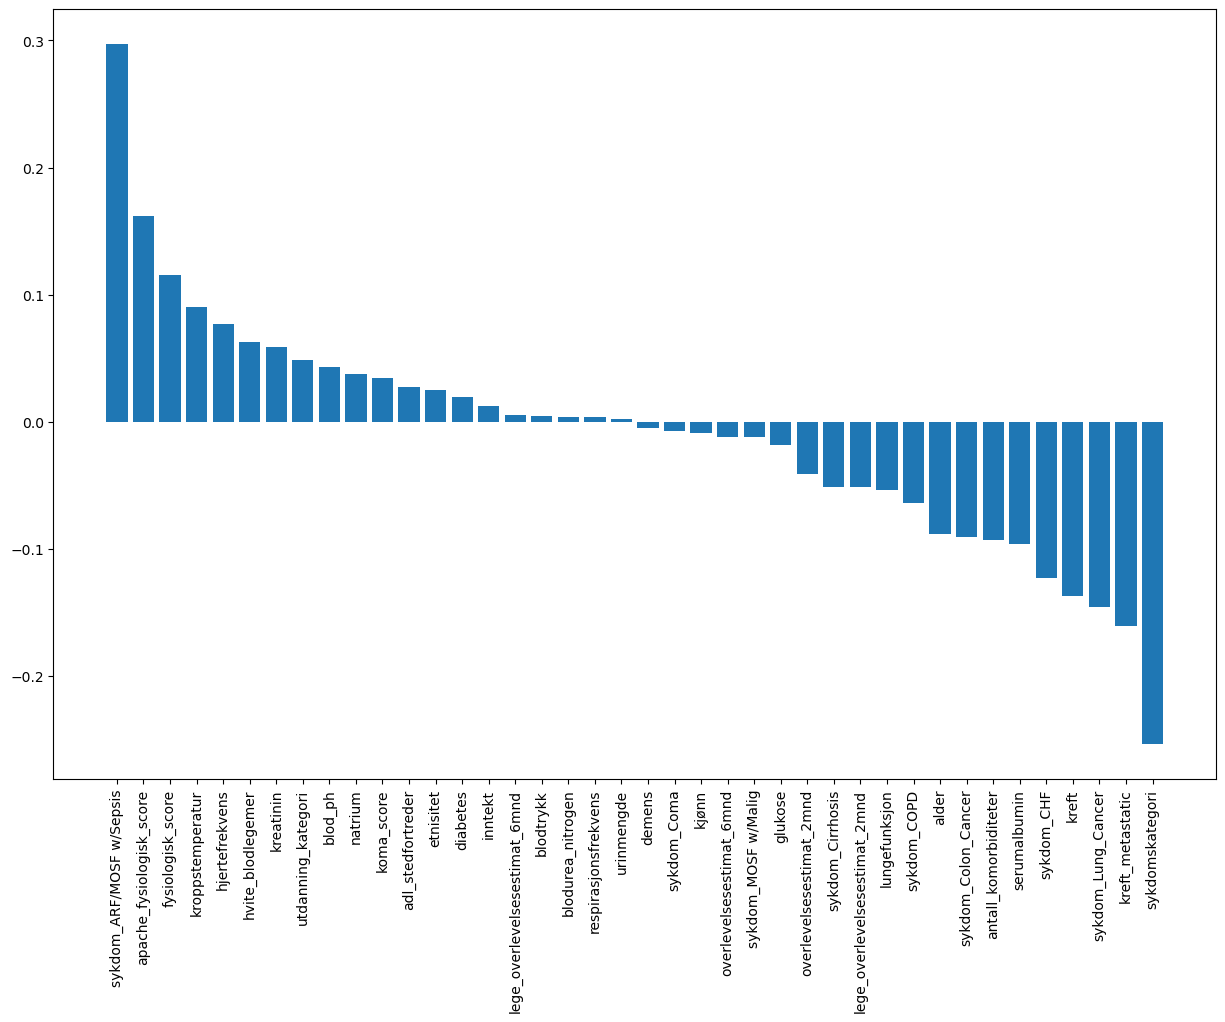

In [763]:
correlation=train_df.corr()
corr_target=correlation['oppholdslengde'].sort_values(ascending=False)
corr_target.drop('oppholdslengde', inplace=True)

plt.figure(figsize=(15,10))
plt.bar(corr_target.index, corr_target.values)
plt.xticks(rotation=90)

plt.show()

In [764]:
correlation_matrix = train_df.corr()

fig = px.imshow(correlation_matrix,
               labels=dict(x='Features', y='Features', color='Correlation'),
               x=correlation_matrix.columns,
               y=correlation_matrix.columns,
               color_continuous_scale='RdBu_r',
               aspect='auto')

fig.update_layout(
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    autosize=False,
    height=1000,
    width=1000
)

fig.show()


## 4.1 Modellering

### 4.2.1 Fyller inn for NaN-verdier

In [765]:
train_df.isnull().sum()

alder                               5
inntekt                          1793
etnisitet                           0
blodtrykk                           0
hvite_blodlegemer                 132
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                    1373
serumalbumin                     1992
kreatinin                          42
natrium                             0
blod_ph                          1354
glukose                          2660
blodurea_nitrogen                2568
urinmengde                       2864
sykdomskategori                     0
antall_komorbiditeter               0
koma_score                          0
adl_stedfortreder                1714
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
lege_overlev

In [766]:
#import missingno as msno

#msno.matrix(train_df)

#plt.figure(figsize=(3, 3))
#msno.heatmap(train_df)
#plt.show()

In [767]:
nan_corr = train_df['blod_ph'].isna().corr(train_df['lungefunksjon'].isna())
print(f"Korrelasjonen mellom NaN-verdiene i blod_ph og lungefunksjon: {nan_corr}")

Korrelasjonen mellom NaN-verdiene i blod_ph og lungefunksjon: 0.9887690322782575


#### 4.2.2 Blod_ph og lungefunksjon

In [768]:
train_df[['blod_ph', 'lungefunksjon']].head()

,blod_ph,lungefunksjon
0,7.279297,404.000
1,7.349609,111.625
2,7.429688,112.500
3,NaN,NaN
4,7.369141,280.750


In [769]:
train_df.loc[:, 'blod_ph'] = train_df['blod_ph'].fillna(7.40)
val_df.loc[:, 'blod_ph'] = val_df['blod_ph'].fillna(7.40)
test_df.loc[:, 'blod_ph'] = test_df['blod_ph'].fillna(7.40)

In [770]:
train_df.loc[:, 'lungefunksjon'] = train_df['lungefunksjon'].fillna(333.3)
val_df.loc[:, 'lungefunksjon'] = val_df['lungefunksjon'].fillna(333.3)
test_df.loc[:, 'lungefunksjon'] = test_df['lungefunksjon'].fillna(333.3)

#### 4.2.3 Glukose og Bloduera nitrogen

In [771]:
print(train_df[['blodurea_nitrogen', 'glukose', 'diabetes']].head(n=20))

    blodurea_nitrogen  glukose  diabetes
0                 NaN      NaN         0
1                 NaN      NaN         0
2                17.0    115.0         1
3                33.0    125.0         0
4                32.0    274.0         0
5                 NaN      NaN         1
6                18.0    149.0         1
7                 NaN      NaN         0
8                 NaN      NaN         0
9                 9.0    179.0         0
10              119.0     82.0         0
11                NaN      NaN         0
12               28.0    246.0         0
13               12.0    199.0         0
14                9.0    100.0         0
15               55.0    100.0         0
16                NaN      NaN         0
17               12.0      NaN         0
18                NaN      NaN         0
19                NaN      NaN         0


In [772]:
train_df.loc[:, 'blodurea_nitrogen'] = train_df['blodurea_nitrogen'].fillna(6.51)
val_df.loc[:, 'blodurea_nitrogen'] = val_df['blodurea_nitrogen'].fillna(6.51)
test_df.loc[:, 'blodurea_nitrogen'] = test_df['blodurea_nitrogen'].fillna(6.51)

In [773]:
train_df.loc[:, 'glukose'] = train_df['glukose'].fillna(85)
val_df.loc[:, 'glukose'] = val_df['glukose'].fillna(85)
test_df.loc[:, 'glukose'] = test_df['glukose'].fillna(85)

#### 4.2.4 Urinmengde

In [774]:
train_df.loc[:, 'urinmengde'] = train_df['urinmengde'].fillna(2502)
val_df.loc[:, 'urinmengde'] = val_df['urinmengde'].fillna(2502)
test_df.loc[:, 'urinmengde'] = test_df['urinmengde'].fillna(2502)

## 4.3.1 Fyller inn NaN-verdier som er MAR (missing at random)

##### Må dele opp train, val og test igjen først. 

In [775]:
X_train = train_df.drop(columns=['oppholdslengde']) 
y_train = train_df['oppholdslengde']                 

X_val = val_df.drop(columns=['oppholdslengde'])      
y_val = val_df['oppholdslengde']                     

X_test = test_df.drop(columns=['oppholdslengde'])    
y_test = test_df['oppholdslengde']     


X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
y_val_copy = y_val.copy()
X_val_copy = X_val.copy()

#### 4.3.2 Finner beste imputasjon for modellene og deres beste hyper parametere

In [776]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


extraTree = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400, random_state=42)
mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', max_iter=500, random_state=42)
gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, alpha=0.9, random_state=42)

param_grids = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [400],
        'model__max_depth': [20],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [5],
        'model__max_features': [0.5]
    },
    'GradientBoostingRegressor': {
        'model__n_estimators': [100],  
        'model__learning_rate': [0.1],
        'model__max_depth': [3],
        'model__max_features': ['log2'],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [5],
        'model__subsample': [1.0],
        'model__alpha': [0.9]
    },
    'MLPRegressor': {
        'model__activation': ['relu'],
        'model__alpha': [0.001],
        'model__hidden_layer_sizes': [(100,)],
        'model__learning_rate': ['constant'],
        'model__learning_rate_init': [0.001],
        'model__solver': ['adam'],
        'model__max_iter': [500]
    }
}

imputers = {
    'SimpleMean': SimpleImputer(strategy='mean'),
    'SimpleMedian': SimpleImputer(strategy='median'),
    'SimpleMostFrequent': SimpleImputer(strategy='most_frequent'),
    'KNN50': KNNImputer(n_neighbors=50),
    'KNN100': KNNImputer(n_neighbors=100),
    'KNN150': KNNImputer(n_neighbors=150),  
}


if run_grid_search_forAll:
    models = [
        ('ExtraTreesRegressor', extraTree),
        ('GradientBoostingRegressor', gradient),
        ('MLPRegressor', mlp)
    ]
    results = []

    for imputer_name, imputer in imputers.items():
        for model_name, model in models:

            pipeline = Pipeline([
                ('imputer', imputer),
                ('model', model)
            ])

            param_grid = param_grids[model_name]
            cv=KFold(n_splits=5, shuffle=True, random_state=42)

            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=cv,  
                scoring='neg_mean_squared_error',
                n_jobs=-1, 
                verbose=1
            )

            if imputer_name.startswith("KNN"):
                imputer_transformer = KNNImputer(n_neighbors=int(imputer_name.replace('KNN', '')))
            else:
                imputer_transformer = imputer

            X_train_imputed = imputer_transformer.fit_transform(X_train_copy)
            X_val_imputed = imputer_transformer.transform(X_val_copy)

            X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_copy.columns)
            X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val_copy.columns)

            grid_search.fit(X_train_imputed, y_train_copy)

            best_model = grid_search.best_estimator_

            y_pred = best_model.predict(X_val_imputed)

            rmse = np.sqrt(mean_squared_error(y_val_copy, y_pred))

            results.append({
                'Imputer': imputer_name,
                'Model': model_name,
                'Best Params': grid_search.best_params_,
                'RMSE': rmse
            })

    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    
    results_df_clean = results_df[['Imputer', 'Model', 'RMSE']].sort_values(by='RMSE')
    print(results_df_clean)



In [777]:
'''if cross_validation:
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error
    import numpy as np
    import pandas as pd

    # Define models
    extraTree = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=450, random_state=42)
    mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', random_state=42)
    gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, random_state=42)

    # Define imputers
    imputers = {
        'SimpleMean': SimpleImputer(strategy='mean'),
        'SimpleMedian': SimpleImputer(strategy='median'),
        'SimpleMostFrequent': SimpleImputer(strategy='most_frequent'),
        'KNN50': KNNImputer(n_neighbors=50),
        'KNN100': KNNImputer(n_neighbors=100),
        'KNN150': KNNImputer(n_neighbors=150),  
    }

    models = [
        mlp,
        gradient,
        extraTree,
    ]

    results = []

    for imputer_name, imputer in imputers.items():
        for model in models:
            pipeline = Pipeline([
                ('imputer', imputer),
                ('model', model)
            ])

            scores = cross_val_score(pipeline, X_train_copy, y_train_copy, cv=5, scoring='neg_mean_squared_error')

            avg_rmse = np.mean(np.sqrt(-scores))

            results.append({
                'Imputer': imputer_name,
                'Model': model.__class__.__name__,
                'RMSE': avg_rmse
            })

    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    
    print(results_df)
'''

"if cross_validation:\n    from sklearn.model_selection import cross_val_score\n    from sklearn.metrics import mean_squared_error\n    import numpy as np\n    import pandas as pd\n\n    # Define models\n    extraTree = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=450, random_state=42)\n    mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', random_state=42)\n    gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, random_state=42)\n\n    # Define imputers\n    imputers = {\n        'SimpleMean': SimpleImputer(strategy='mean'),\n        'SimpleMedian': SimpleImputer(strategy='median'),\n        'SimpleMostFrequent': SimpleImputer(strategy='most_frequent'),\n        'KNN50': KNNImputer(n_neighbors=50),\n        'KNN100': KNNImputer(n_neighbors

In [778]:
'''if cross_validation:

    top_5_results = results_df.nsmallest(5, 'RMSE')

    fig = px.line(
        results_df, 
        x='Imputer',  
        y='RMSE',     
        color='Model', 
        title='RMSE for 5 beste Imputers og Modeller'
    )

    fig.show()'''

"if cross_validation:\n\n    top_5_results = results_df.nsmallest(5, 'RMSE')\n\n    fig = px.line(\n        results_df, \n        x='Imputer',  \n        y='RMSE',     \n        color='Model', \n        title='RMSE for 5 beste Imputers og Modeller'\n    )\n\n    fig.show()"

In [779]:
if fill_in_mean:
    imputer = SimpleImputer(strategy='mean')

    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=train_df.drop('oppholdslengde', axis=1).columns)

    X_val = imputer.transform(X_val)
    X_val = pd.DataFrame(X_val, columns=val_df.drop('oppholdslengde', axis=1).columns)

    X_test = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=test_df.drop('oppholdslengde', axis=1).columns)

    train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    val_df = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_df.isnull().sum() 

alder                               5
inntekt                          1793
etnisitet                           0
blodtrykk                           0
hvite_blodlegemer                 132
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                       0
serumalbumin                     1992
kreatinin                          42
natrium                             0
blod_ph                             0
glukose                             0
blodurea_nitrogen                   0
urinmengde                          0
sykdomskategori                     0
antall_komorbiditeter               0
koma_score                          0
adl_stedfortreder                1714
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
lege_overlev

In [780]:
from sklearn.impute import KNNImputer

if fill_in_knn:
    imputer = KNNImputer(n_neighbors=100) 

    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=train_df.drop('oppholdslengde', axis=1).columns)

    X_val = imputer.transform(X_val)
    X_val = pd.DataFrame(X_val, columns=val_df.drop('oppholdslengde', axis=1).columns)

    X_test = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=test_df.drop('oppholdslengde', axis=1).columns)

    train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    val_df = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

X_train.isnull().sum()


alder                            0
inntekt                          0
etnisitet                        0
blodtrykk                        0
hvite_blodlegemer                0
hjertefrekvens                   0
respirasjonsfrekvens             0
kroppstemperatur                 0
lungefunksjon                    0
serumalbumin                     0
kreatinin                        0
natrium                          0
blod_ph                          0
glukose                          0
blodurea_nitrogen                0
urinmengde                       0
sykdomskategori                  0
antall_komorbiditeter            0
koma_score                       0
adl_stedfortreder                0
fysiologisk_score                0
apache_fysiologisk_score         0
overlevelsesestimat_2mnd         0
overlevelsesestimat_6mnd         0
diabetes                         0
demens                           0
lege_overlevelsesestimat_2mnd    0
lege_overlevelsesestimat_6mnd    0
kjønn               

## 4.4.1 Modellering

#### 4.4.2 Grunnlinjemodell

In [781]:
baseline = DummyRegressor(strategy='mean') 
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
 
score = {}
score["actual"] = y_val
score["baseline"] = y_pred_baseline 

print(f"RMSE for baseline: {rmse_baseline}")

RMSE for baseline: 20.603790732142762


#### 4.4.3 Tester ulike modeller

In [782]:
models = [tree.DecisionTreeRegressor(random_state=42), ensemble.GradientBoostingRegressor(random_state=42), ensemble.ExtraTreesRegressor(random_state=42), 
          ensemble.RandomForestRegressor(random_state=42),neural_network.MLPRegressor(random_state=42),linear_model.Lasso(random_state=42)]

bestmodel = []
best_rmse = rmse_baseline

for reg in models:
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_val) 
    reg_score = float(np.sqrt(metrics.mean_squared_error(y_val, reg_pred)))
    if reg_score <= best_rmse:
        best_rmse = reg_score
        bestmodel = reg    
    print("model: " + str(reg) + " , score is " + str(reg_score))
print("best model: " + str(bestmodel) + " , score is " + str(best_rmse))

model: DecisionTreeRegressor(random_state=42) , score is 31.928827100286664
model: GradientBoostingRegressor(random_state=42) , score is 19.30320195115198
model: ExtraTreesRegressor(random_state=42) , score is 19.191645041437997
model: RandomForestRegressor(random_state=42) , score is 20.00269533131076
model: MLPRegressor(random_state=42) , score is 20.855044774873015
model: Lasso(random_state=42) , score is 19.52972380236521
best model: ExtraTreesRegressor(random_state=42) , score is 19.191645041437997


#### 4.4.4  Grunnlinjemodell Log

In [783]:
train_df['oppholdslengde_log'] = np.log(train_df['oppholdslengde']) 

fig = px.box(train_df, x='oppholdslengde_log', title="Box Plot of 'Log-Transformert oppholdslengde' kolonne")

fig.show()

In [784]:
y_train_log = np.log(y_train)

baseline_log = DummyRegressor(strategy='mean') 
baseline_log.fit(X_train, y_train_log)

y_pred_log = baseline_log.predict(X_val)
y_pred = np.exp(y_pred_log)  
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred))
mae_log = mean_absolute_error(y_val, y_pred)

print(f"RMSE med log-transformasjon: {rmse_log}")

RMSE med log-transformasjon: 21.300741520701333


#### Flere modeller for Log-transformasjon. 

In [785]:
y_train_log = np.log(y_train)

models = [
    tree.DecisionTreeRegressor(random_state=42),
    ensemble.GradientBoostingRegressor(random_state=42),
    ensemble.ExtraTreesRegressor(random_state=42),
    ensemble.RandomForestRegressor(random_state=42),
    neural_network.MLPRegressor(random_state=42),
    linear_model.Lasso(random_state=42)
]

bestmodel = None
best_rmse = rmse_log

X_val = pd.DataFrame(X_val, columns=X_train.columns)

for reg in models:
    reg.fit(X_train, y_train_log)  
    reg_pred_log = reg.predict(X_val)  
    reg_pred = np.exp(reg_pred_log) 

    reg_score = np.sqrt(metrics.mean_squared_error(y_val, reg_pred))

    if reg_score <= best_rmse:
        best_rmse = reg_score
        bestmodel = reg

    print(f"Model: {str(reg)} , RMSE: {reg_score}")

print(f"The best model is: {str(bestmodel)} with RMSE: {best_rmse}")


Model: DecisionTreeRegressor(random_state=42) , RMSE: 28.584870606427568
Model: GradientBoostingRegressor(random_state=42) , RMSE: 19.606993742135014
Model: ExtraTreesRegressor(random_state=42) , RMSE: 19.277687192814273
Model: RandomForestRegressor(random_state=42) , RMSE: 19.35136806455369
Model: MLPRegressor(random_state=42) , RMSE: 110.46646019804066
Model: Lasso(random_state=42) , RMSE: 21.11532733241442
The best model is: ExtraTreesRegressor(random_state=42) with RMSE: 19.277687192814273


## 4.5.1 Hyperparameter-tuning


#### 4.5.2 ExtraTreeRegressor

In [786]:
if extraTrees_first: 
    param_grid = {
        'n_estimators': [400],
        'max_depth': [50],
        'min_samples_split': [2], 
        'min_samples_leaf': [5],  
        'max_features': [0.5],
    }

    model = ExtraTreesRegressor(random_state=42)
    
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,  
        n_jobs=-1, 
        verbose=1,
        scoring='neg_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_Et = grid_search.best_estimator_
    y_pred_et = best_model_Et.predict(X_val)

    rmse_et = np.sqrt(mean_squared_error(y_val, y_pred_et))
    print(f"RMSE på valideringssettet: {rmse_et}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parametere: {'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 400}
RMSE på valideringssettet: 18.68770413592707


In [787]:
if extraTrees_first:
    df = pd.DataFrame({
    'Faktisk oppholdslengde': y_val,
    'Predikert oppholdslengde (ETR)': y_pred_et,
    'Predikert oppholdslengde (Baseline)': y_pred_baseline
})


    fig_etr = px.scatter(df, 
                    x='Faktisk oppholdslengde', 
                    y='Predikert oppholdslengde (ETR)', 
                    labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (ETR)'},
                    title='Faktisk vs. Predikert oppholdslengde (ETR)')

    fig_etr.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                 line=dict(color='red', dash='dash'))

    fig_etr.show()

#### 4.5.2 GradientBoosting

In [788]:
if gradientBoosting_first:
    param_grid = {
        'learning_rate': [0.1], 
        'max_depth': [3], 
        'max_features': ['log2'], 
        'min_samples_leaf': [5],  
        'min_samples_split': [2],  
        'subsample': [1.0],  
        'alpha': [0.8, 0.9]  
    }

    model = GradientBoostingRegressor(random_state=42)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_mean_squared_error'  
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")
    y_pred_gb = grid_search.best_estimator_.predict(X_val)
    rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
    print(f"RMSE på valideringssettet: {rmse_gb}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste parametere: {'alpha': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 1.0}
RMSE på valideringssettet: 19.027409557022665


#### Printer ut forhold mellom de faktiske verdiene og predikerte

In [789]:
if gradientBoosting_first:
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (GradientBoosting)': y_pred_gb,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })


    fig_rf = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (GradientBoosting)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (GradientBoosting)'},
                        title='Faktisk vs. Predikert oppholdslengde (GradientBoosting)')

    fig_rf.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_rf.show()

##### Sjekker viktig informasjon for modellen

In [790]:
model= GradientBoostingRegressor(random_state=42, alpha=0.9, learning_rate=0.05, loss='absolute_error', max_depth=5, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=1.0)

model.fit(X_train, y_train)
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))



                      Feature  Importance
            fysiologisk_score    0.102702
              sykdomskategori    0.097161
     overlevelsesestimat_2mnd    0.079818
     apache_fysiologisk_score    0.068112
     sykdom_ARF/MOSF w/Sepsis    0.066062
     overlevelsesestimat_6mnd    0.062225
lege_overlevelsesestimat_2mnd    0.050880
            adl_stedfortreder    0.046656
lege_overlevelsesestimat_6mnd    0.043117
                        alder    0.040197
                   koma_score    0.025962
             kroppstemperatur    0.022752
           sykdom_Lung_Cancer    0.022593
                   sykdom_CHF    0.021882
                    blodtrykk    0.021191
                lungefunksjon    0.020563
            hvite_blodlegemer    0.017907
               hjertefrekvens    0.017828
                      blod_ph    0.017640
         respirasjonsfrekvens    0.017640
             kreft_metastatic    0.015764
                 serumalbumin    0.015047
                   urinmengde    0

In [791]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()

#### 4.5.3 Lasso-modell

In [792]:
if Lasso_first: 
    model = Lasso(random_state=42)

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  
    }

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        n_jobs=-1, 
        verbose=1,
        scoring='neg_mean_squared_error' 
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_lasso = grid_search.best_estimator_

    y_pred_lasso = best_model_lasso.predict(X_val)

    rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))
    print(f"RMSE på valideringssettet: {rmse_lasso}")


In [793]:
if Lasso_first: 
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (Lasso)': y_pred_lasso,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline 
    })

    fig_rf = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (Lasso)',  
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (Lasso)'},
                        title='Faktisk vs. Predikert oppholdslengde (Lasso)')

    fig_rf.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_rf.show()

#### 4.4.4 MLP

In [794]:
if mlp_first:
    param_grid = {
        'hidden_layer_sizes': [(100,)],  
        'activation': ['relu'],  
        'solver': ['adam'],  
        'alpha': [0.001], 
        'learning_rate': ['constant'],  
        'learning_rate_init': [0.001]
    }
    
    model = MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)
    cv= KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1,  
        verbose=1,  
        scoring='neg_mean_squared_error'  
    )
    
    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_mlp = grid_search.best_estimator_.predict(X_val)

    rmse_mlp = np.sqrt(mean_squared_error(y_val, y_pred_mlp))
    print(f"RMSE på valideringssettet: {rmse_mlp}")

In [795]:
if mlp_first:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (MLP)': y_pred_mlp,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    fig_mlp = px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (MLP)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (MLP)'},
                        title='Faktisk vs. Predikert oppholdslengde (MLP)')

    fig_mlp.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_mlp.show()


#### 4.4.5 Log-modell, RandomForestRegressor.

In [796]:
from sklearn.ensemble import RandomForestRegressor
if RandomForest_log:
    param_grid = {
        'n_estimators': [400],
        'max_depth': [20],
        'min_samples_split': [2],
        'min_samples_leaf': [2],
        'oob_score': [True],
        'max_features': ['log2'],
        'bootstrap': [True]
    }
    
    model = ExtraTreesRegressor(random_state=42)
    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    y_train_log = np.log(y_train)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,              
        n_jobs=-1,           
        verbose=1, 
    )
    
    grid_search.fit(X_train, y_train_log)  

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_r_log = grid_search.best_estimator_.predict(X_val)
    y_pred_r = np.exp(y_pred_r_log)  

    rmse_t = np.sqrt(mean_squared_error(y_val, y_pred_r))
    print(f"RMSE på valideringssettet: {rmse_t}")


#### Visualiserer predikerte verdi opp mot den faktiske verdien. 

In [797]:
if RandomForest_log:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (RandomForest_log)': y_pred_r,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    fig_ExtraTree_log= px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (RandomForest_log)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (RandomForest_log)'},
                        title='Faktisk vs. Predikert oppholdslengde (RandomForest_log)')

    fig_ExtraTree_log.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_ExtraTree_log.show()    


#### 4.4.6 Samler alle modeller, oversikt. 

In [798]:
extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400, random_state=42)
Lasso = Lasso(alpha=0.001, random_state=42)
mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001,random_state=42)
gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, random_state=42)
RandomForest_log = RandomForestRegressor(n_estimators=400, max_depth=20, min_samples_split=2, min_samples_leaf=2, oob_score=True, max_features='log2', bootstrap=True,random_state=42)

models = [extraTree, mlp, gradient, RandomForest_log, Lasso]
model_rmse = {} 

for model in models:
    if model == RandomForest_log:
        y_train_log = np.log(y_train)
        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_val)
        y_pred = np.exp(y_pred_log)  
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
   
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    model_rmse[model.__class__.__name__] = rmse
    print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}")

best_model_name = min(model_rmse, key=model_rmse.get)
best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]

print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {model_rmse[best_model_name]:.4f}")

ExtraTreesRegressor - RMSE: 18.6949
MLPRegressor - RMSE: 20.8475
GradientBoostingRegressor - RMSE: 19.0274
RandomForestRegressor - RMSE: 19.4603
Lasso - RMSE: 19.2700

Beste modell basert på RMSE på valideringssettet: ExtraTreesRegressor med RMSE: 18.6949


#### 4.5.1 Overfitting.

In [799]:
models = {
    'RandomForest_log': RandomForest_log,
    'ExtraTreesRegressor': extraTree,
    'GradientBoostingRegressor': gradient,
    'MLPRegressor': mlp,
    'Lasso':Lasso
}
train_rmse_scores = {}
val_rmse_scores = {}

for name, model in models.items():
    print(f"Training model: {name}")
    
    if 'Log' in name:
        y_train_log = np.log(y_train)
        y_val_log = np.log(y_val)
        model.fit(X_train, y_train_log)
        
        y_train_pred_log = model.predict(X_train)
        y_val_pred_log = model.predict(X_val)
        
        y_train_pred = np.exp(y_train_pred_log)
        y_val_pred = np.exp(y_val_pred_log)
    else:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_rmse_scores[name] = train_rmse
    val_rmse_scores[name] = val_rmse

    print(f"{name} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")



Training model: RandomForest_log
RandomForest_log - Training RMSE: 11.4138, Validation RMSE: 18.9147
Training model: ExtraTreesRegressor
ExtraTreesRegressor - Training RMSE: 13.9927, Validation RMSE: 18.6949
Training model: GradientBoostingRegressor
GradientBoostingRegressor - Training RMSE: 18.7112, Validation RMSE: 19.0274
Training model: MLPRegressor
MLPRegressor - Training RMSE: 20.9175, Validation RMSE: 20.8475
Training model: Lasso
Lasso - Training RMSE: 20.0667, Validation RMSE: 19.2700


In [800]:
rmse_data = pd.DataFrame({
    'Model': list(train_rmse_scores.keys()),
    'Train RMSE': list(train_rmse_scores.values()),
    'Validation RMSE': list(val_rmse_scores.values())
})

rmse_melted = rmse_data.melt(id_vars='Model', value_vars=['Train RMSE', 'Validation RMSE'], 
                             var_name='Type', value_name='RMSE')

fig = px.bar(rmse_melted, x='Model', y='RMSE', color='Type', barmode='group', title="Overfitting i modellene")

fig.show()

In [801]:
'''from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")  # Changed from Score to RMSE
    
    # Adding scoring='neg_mean_squared_error' to compute RMSE
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    # Convert negative MSE to positive RMSE
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation RMSE")

    plt.legend(loc="best")
    return plt

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

lasso_model = Lasso(alpha=0.001, random_state=42) 
rf = RandomForestRegressor(n_estimators=250, max_depth=20, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, oob_score=True, random_state=42)
et = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=450, random_state=42)
mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', random_state=42)
gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=3, min_samples_split=2, subsample=1.0, random_state=42)

g = plot_learning_curve(lasso_model, "Lasso Learning Curves", X_train, y_train, cv=kfold)  
g = plot_learning_curve(rf, "ET_log Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(et, "ExtraTrees Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(mlp, "MLP Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gb, "GradientBoosting Learning Curves", X_train, y_train, cv=kfold)'''



'from sklearn.linear_model import Lasso\nfrom sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor\nfrom sklearn.model_selection import KFold\n\n\ndef plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,\n                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):\n    """Generate a simple plot of the test and training learning curve"""\n    plt.figure()\n    plt.title(title)\n    if ylim is not None:\n        plt.ylim(*ylim)\n    plt.xlabel("Training examples")\n    plt.ylabel("RMSE")  # Changed from Score to RMSE\n    \n    # Adding scoring=\'neg_mean_squared_error\' to compute RMSE\n    train_sizes, train_scores, test_scores = learning_curve(\n        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=\'neg_mean_squared_error\')\n    \n    # Convert negative MSE to positive RMSE\n    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))\n    train_scores_std = np.std(train_scores, axis=1)\n    test_scores_mean = np.sqr

##  4.5.1 Variabelutvinning

In [802]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.00,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,2.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
1,65.26495,1.00,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,2.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2,71.98395,0.99,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.783123,1.699951,137.0,7.429688,115.0,17.00,2095.0,1.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00
3,52.26599,3.00,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.959797,1.699951,135.0,7.400000,125.0,33.00,1150.0,4.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.72
4,69.77100,3.00,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.875820,1.299805,138.0,7.369141,274.0,32.00,1250.0,4.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,2.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5409,81.90594,0.00,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,2.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.60
5410,60.37000,3.00,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.917791,0.699951,136.0,7.400000,99.0,6.00,3550.0,4.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00
5411,80.05499,1.00,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,2.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00


#### 4.5.2 Signifikante forksjeller mellom opphold over 150 dager, og mindre?

In [803]:
df_train = X_train.copy()  
df_train['oppholdslengde'] = y_train  

short_stays = df_train[df_train['oppholdslengde'] <= 150].copy()  
long_stays = df_train[df_train['oppholdslengde'] > 150].copy()  

short_stay_summary = short_stays.select_dtypes(include=[np.number]).mean()
long_stay_summary = long_stays.select_dtypes(include=[np.number]).mean()

comparison = pd.DataFrame({
    'Long Stay Mean': long_stay_summary,
    'Short Stay Mean': short_stay_summary
})

print(comparison.sort_values(by='Long Stay Mean', ascending=False))



                               Long Stay Mean  Short Stay Mean
urinmengde                        2640.263158      2356.319444
lungefunksjon                      232.227961       262.145327
oppholdslengde                     190.789474        17.274008
natrium                            140.578947       137.575640
hjertefrekvens                     110.842105        97.648313
glukose                            105.421053       123.019651
blodtrykk                           86.263158        84.203652
alder                               55.969817        62.747737
apache_fysiologisk_score            50.421053        37.590100
kroppstemperatur                    37.923109        37.142536
fysiologisk_score                   29.592105        25.513071
respirasjonsfrekvens                26.947368        23.470708
hvite_blodlegemer                   16.114309        12.360015
blodurea_nitrogen                   12.058947        19.978932
koma_score                          10.263158        12

#### 4.5.3 Binære variabler. 

In [804]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.00,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,2.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
1,65.26495,1.00,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,2.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2,71.98395,0.99,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.783123,1.699951,137.0,7.429688,115.0,17.00,2095.0,1.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00
3,52.26599,3.00,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.959797,1.699951,135.0,7.400000,125.0,33.00,1150.0,4.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.72
4,69.77100,3.00,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.875820,1.299805,138.0,7.369141,274.0,32.00,1250.0,4.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,2.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5409,81.90594,0.00,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,2.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.60
5410,60.37000,3.00,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.917791,0.699951,136.0,7.400000,99.0,6.00,3550.0,4.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00
5411,80.05499,1.00,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,2.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00


In [805]:
if map_lungefunksjon:
    X_train['lungefunksjon']=pd.cut(X_train['lungefunksjon'],
                                    bins=[0, 100, 200, 300, float('inf')], 
                                    labels = [3,2,1,0], ordered=False)
    X_train['lungefunksjon'] = X_train['lungefunksjon'].astype('int64')

    X_val['lungefunksjon']=pd.cut(X_val['lungefunksjon'],
                                    bins=[0, 100, 200, 300, float('inf')], 
                                    labels = [3,2,1,0], ordered=False)
    X_val['lungefunksjon'] = X_val['lungefunksjon'].astype('int64')

    X_test['lungefunksjon']=pd.cut(X_test['lungefunksjon'],
                                    bins=[0, 100, 200, 300, float('inf')], 
                                    labels = [3,2,1,0], ordered=False)
    X_test['lungefunksjon'] = X_test['lungefunksjon'].astype('int64')





In [806]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.00,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,2.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
1,65.26495,1.00,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,2.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2,71.98395,0.99,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.783123,1.699951,137.0,7.429688,115.0,17.00,2095.0,1.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00
3,52.26599,3.00,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.959797,1.699951,135.0,7.400000,125.0,33.00,1150.0,4.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.72
4,69.77100,3.00,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.875820,1.299805,138.0,7.369141,274.0,32.00,1250.0,4.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,2.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5409,81.90594,0.00,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,2.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.60
5410,60.37000,3.00,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.917791,0.699951,136.0,7.400000,99.0,6.00,3550.0,4.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00
5411,80.05499,1.00,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,2.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00


###### Glukose

In [807]:
if binære_variabler:
    X_train['glukose'] = pd.cut(X_train['glukose'],
                                bins=[-float('inf'), 70, 100, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_train['glukose'] = X_train['glukose'].astype(float)

    X_val['glukose'] = pd.cut(X_val['glukose'],
                              bins=[-float('inf'), 70, 100, float('inf')],
                              labels=[1, 0, 1], ordered=False)
    X_val['glukose'] = X_val['glukose'].astype(float)

    X_test['glukose'] = pd.cut(X_test['glukose'],
                               bins=[-float('inf'), 70, 100, float('inf')],
                               labels=[1, 0, 1], ordered=False)
    X_test['glukose'] = X_test['glukose'].astype(float)


##### Bloduera_nitrogen

In [808]:
if binære_variabler:
    X_train['blodurea_nitrogen'] = pd.cut(X_train['blodurea_nitrogen'],
                             bins=[-float('inf'), 6, 24, float('inf')],
                             labels=[1, 0, 1], ordered=False)
    X_train['blodurea_nitrogen'] = X_train['blodurea_nitrogen'].astype(float)

    X_val['blodurea_nitrogen'] = pd.cut(X_val['blodurea_nitrogen'],
                           bins=[-float('inf'), 6, 24, float('inf')],
                           labels=[1, 0, 1], ordered=False)
    X_val['blodurea_nitrogen'] = X_val['blodurea_nitrogen'].astype(float)
    
    X_test['blodurea_nitrogen'] = pd.cut(X_test['blodurea_nitrogen'],
                            bins=[-float('inf'), 6, 24, float('inf')],
                            labels=[1, 0, 1], ordered=False)
    X_test['blodurea_nitrogen'] = X_test['blodurea_nitrogen'].astype(float)

##### Urinmengde

In [809]:
if binære_variabler:
    X_train['urinmengde'] = pd.cut(X_train['urinmengde'],
                                bins=[-float('inf'), 2500, 2502, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_train['urinmengde'] = X_train['urinmengde'].astype(float)
    
    X_val['urinmengde'] = pd.cut(X_val['urinmengde'],
                              bins=[-float('inf'), 2500, 2502, float('inf')],
                              labels=[1, 0, 1], ordered=False)
    val_df['urinmengde'] = X_val['urinmengde'].astype(float)
    
    X_test['urinmengde'] = pd.cut(X_test['urinmengde'],
                               bins=[-float('inf'), 2500, 2502, float('inf')],
                               labels=[1, 0, 1], ordered=False)
    X_test['urinmengde'] = X_test['urinmengde'].astype(float)

##### Blod_ph

In [810]:
if binære_variabler:
    X_train['blod_ph'] = pd.cut(X_train['blod_ph'],
                             bins=[-float('inf'), 7.35, 7.45, float('inf')],
                             labels=[1, 0, 1], ordered=False)
    X_train['blod_ph'] = X_train['blod_ph'].astype(float)
    
    X_val['blod_ph'] = pd.cut(X_val['blod_ph'],
                           bins=[-float('inf'), 7.35, 7.45, float('inf')],
                           labels=[1, 0, 1], ordered=False)
    X_val['blod_ph'] = X_val['blod_ph'].astype(float)
    
    X_test['blod_ph'] = pd.cut(X_test['blod_ph'],
                            bins=[-float('inf'), 7.35, 7.45, float('inf')],
                            labels=[1, 0, 1], ordered=False)
    X_test['blod_ph'] = X_test['blod_ph'].astype(float)

##### Lungefunksjon

In [811]:
if binære_variabler:
    
    X_train['lungefunksjon'] = pd.cut(X_train['lungefunksjon'], 
                                       bins=[-float('inf'), 300, float('inf')], 
                                       labels=[1, 0], 
                                       include_lowest=True)
    X_val['lungefunksjon'] = pd.cut(X_val['lungefunksjon'], 
                                     bins=[-float('inf'), 300, float('inf')], 
                                     labels=[1, 0], 
                                     include_lowest=True)
    X_test['lungefunksjon'] = pd.cut(X_test['lungefunksjon'], 
                                      bins=[-float('inf'), 300, float('inf')], 
                                      labels=[1, 0], 
                                      include_lowest=True)
    
    X_train['lungefunksjon'] = X_train['lungefunksjon'].astype(int)
    X_val['lungefunksjon'] = X_val['lungefunksjon'].astype(int)
    X_test['lungefunksjon'] = X_test['lungefunksjon'].astype(int)

In [812]:
if binære_variabler:
    X_train['kroppstemperatur']=pd.cut(X_train['kroppstemperatur'], 
                                   bins=[-float('inf'), 36.5, 37.5, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['kroppstemperatur'] = X_train['kroppstemperatur'].astype(float)
    
    X_val['kroppstemperatur']=pd.cut(X_val['kroppstemperatur'],
                                bins=[-float('inf'), 36.5, 37.5, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_val['kroppstemperatur'] = X_val['kroppstemperatur'].astype(float)
    
    X_test['kroppstemperatur']=pd.cut(X_test['kroppstemperatur'],
                                bins=[-float('inf'), 36.5, 37.5, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_test['kroppstemperatur'] = X_test['kroppstemperatur'].astype(float)


In [813]:
if binære_variabler:
    X_train['hvite_blodlegemer']=pd.cut(X_train['hvite_blodlegemer'],
                                   bins=[-float('inf'), 4.5, 11, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['hvite_blodlegemer'] = X_train['hvite_blodlegemer'].astype(float)
    
    X_val['hvite_blodlegemer']=pd.cut(X_val['hvite_blodlegemer'],
                                    bins=[-float('inf'), 4.5, 11, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['hvite_blodlegemer'] = X_val['hvite_blodlegemer'].astype(float)
    
    X_test['hvite_blodlegemer']=pd.cut(X_test['hvite_blodlegemer'],
                                    bins=[-float('inf'), 4.5, 11, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['hvite_blodlegemer'] = X_test['hvite_blodlegemer'].astype(float)

In [814]:
if binære_variabler:
    X_train['kreatinin']=pd.cut(X_train['kreatinin'],
                                   bins=[-float('inf'), 0.7, 1.3, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['kreatinin'] = X_train['kreatinin'].astype(float)
    
    X_val['kreatinin']=pd.cut(X_val['kreatinin'],
                                    bins=[-float('inf'),0.7, 1.3, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['kreatinin'] = X_val['kreatinin'].astype(float)
    
    X_test['kreatinin']=pd.cut(X_test['kreatinin'],
                                    bins=[-float('inf'), 0.7, 1.3, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['kreatinin'] = X_test['kreatinin'].astype(float)

In [815]:
if binære_variabler:
    X_train['natrium']=pd.cut(X_train['natrium'],
                                   bins=[-float('inf'), 135, 145, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['natrium'] = X_train['natrium'].astype(float)
    
    X_val['natrium']=pd.cut(X_val['natrium'],
                                    bins=[-float('inf'),135, 145, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['natrium'] = X_val['natrium'].astype(float)
    
    X_test['natrium']=pd.cut(X_test['natrium'],
                                    bins=[-float('inf'), 135, 145, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['natrium'] = X_test['natrium'].astype(float)

In [816]:
if binære_variabler:
    X_train['serumalbumin']=pd.cut(X_train['serumalbumin'],
                                   bins=[-float('inf'), 3.4, 5.4, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['serumalbumin'] = X_train['serumalbumin'].astype(float)
    
    X_val['serumalbumin']=pd.cut(X_val['serumalbumin'],
                                    bins=[-float('inf'),3.4, 5.4, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['serumalbumin'] = X_val['serumalbumin'].astype(float)
    
    X_test['serumalbumin']=pd.cut(X_test['serumalbumin'],
                                    bins=[-float('inf'), 3.4, 5.4, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['serumalbumin'] = X_test['serumalbumin'].astype(float)

#### 4.5.4 Prøver å trene modellen på korte opphold, setter ned topp 5%

In [817]:
if if_clip_5:
    q95= y_train.quantile(0.95)
    y_train=y_train.clip(upper=q95)

In [818]:
if if_clip_5:
    y_train_95 = y_train.clip(upper=q95)

    df_winsorized = pd.DataFrame({'Fjernet 5% topp av oppholdslengde': y_train_95})

    fig = px.box(df_winsorized, x='Fjernet 5% topp av oppholdslengde', title="Fjernet 5% topp av oppholdslengde")
    fig.update_layout(
        yaxis_title="Oppholdslengde (dager)",
        xaxis_title="Oppholdslengde"
    )
    fig.show()

In [819]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.00,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,2.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
1,65.26495,1.00,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,2.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2,71.98395,0.99,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.783123,1.699951,137.0,7.429688,115.0,17.00,2095.0,1.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00
3,52.26599,3.00,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.959797,1.699951,135.0,7.400000,125.0,33.00,1150.0,4.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.72
4,69.77100,3.00,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.875820,1.299805,138.0,7.369141,274.0,32.00,1250.0,4.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,2.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5409,81.90594,0.00,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,2.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.60
5410,60.37000,3.00,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.917791,0.699951,136.0,7.400000,99.0,6.00,3550.0,4.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00
5411,80.05499,1.00,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,2.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00


#### Slår sammen verdier med høy korrelasjon. 

In [820]:
if merge_apache_fysiologisk_score:
    X_train['fysiologisk_score_merge'] = (X_train['fysiologisk_score'] + X_train['apache_fysiologisk_score']) / 2
    X_val['fysiologisk_score_merge'] = (X_val['fysiologisk_score'] + X_val['apache_fysiologisk_score']) / 2
    X_test['fysiologisk_score_merge'] = (X_test['fysiologisk_score'] + X_test['apache_fysiologisk_score']) / 2

    X_train.drop(columns=['fysiologisk_score', 'apache_fysiologisk_score'], inplace=True)
    X_val.drop(columns=['fysiologisk_score', 'apache_fysiologisk_score'], inplace=True)
    X_test.drop(columns=['fysiologisk_score', 'apache_fysiologisk_score'], inplace=True)

In [821]:
if merge_overlevelsesestimater:
    X_train['overlevelsesestimat'] = (X_train['overlevelsesestimat_2mnd'] + X_train['overlevelsesestimat_6mnd']) / 2
    X_val['overlevelsesestimat'] = (X_val['overlevelsesestimat_2mnd'] + X_val['overlevelsesestimat_6mnd']) / 2
    X_test['overlevelsesestimat'] = (X_test['overlevelsesestimat_2mnd'] + X_test['overlevelsesestimat_6mnd']) / 2

    X_train.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)
    X_val.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)
    X_test.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)

    X_train['lege_overlevelsesestimat'] = (X_train['lege_overlevelsesestimat_2mnd'] + X_train['lege_overlevelsesestimat_6mnd']) / 2
    X_val['lege_overlevelsesestimat'] = (X_val['lege_overlevelsesestimat_2mnd'] + X_val['lege_overlevelsesestimat_6mnd']) / 2
    X_test['lege_overlevelsesestimat'] = (X_test['lege_overlevelsesestimat_2mnd'] + X_test['lege_overlevelsesestimat_6mnd']) / 2

    X_train.drop(columns=['lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd'], inplace=True)
    X_val.drop(columns=['lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd'], inplace=True)
    X_test.drop(columns=['lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd'], inplace=True)



In [822]:
if sykdomkategori_gjennomsnitt: 
    df_train = X_train.copy()
    df_train['oppholdslengde'] = y_train

    sykdom_kategorier = ['sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 
                         'sykdom_Colon_Cancer', 'sykdom_Lung_Cancer', 'sykdom_Coma', 
                         'sykdom_MOSF w/Malig', 'diabetes', 'demens','kreft_metastatic', 'kreft']
    
    for sykdom in sykdom_kategorier:
        sykdom_mean = df_train[df_train[sykdom] == 1]['oppholdslengde'].mean()
    
        df_train.loc[df_train[sykdom] == 1, 'oppholdslengde'] = df_train.loc[df_train[sykdom] == 1, 'oppholdslengde'].clip(upper=sykdom_mean)

    X_train = df_train.drop('oppholdslengde', axis=1)
    y_train = df_train['oppholdslengde']

In [823]:
if sykdomkategori_gjennomsnitt:
    disease_cols = { 
        'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 
        'sykdom_Colon_Cancer', 'sykdom_Lung_Cancer', 'sykdom_Coma', 
        'sykdom_MOSF w/Malig', 'diabetes', 'demens','kreft_metastatic', 'kreft'
    }

    disease_cols = [col for col in disease_cols if col in df_train.columns]

    disease_melted = pd.melt(df_train, 
                                id_vars=['oppholdslengde'], 
                                value_vars=disease_cols,
                                var_name='sykdom',
                                value_name='har_sykdom'
    )
    disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

    fig = px.box(disease_melted, 
                x='sykdom', 
                y='oppholdslengde',
                color='sykdom',
                title='Oppholdslengde i forhold til sykdomskategori',
                labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
                width=1000,
                height=700
    )
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()


#### 4.5.6 Sjekker hvor mange sykdommer en har når du har et lengre opphold

In [824]:
df_train = X_train.copy()
df_train['oppholdslengde'] = y_train  

short_stays = df_train[df_train['oppholdslengde'] <= 150].copy()
long_stays = df_train[df_train['oppholdslengde'] > 150].copy()

X_train_stopshort = short_stays.drop('oppholdslengde', axis=1)  
y_train_stopshort = short_stays['oppholdslengde']  

X_train_long = long_stays.drop('oppholdslengde', axis=1)
y_train_long = long_stays['oppholdslengde']

short_stays['stay_type'] = 'Short Stay'
long_stays['stay_type'] = 'Long Stay'
combined_stays = pd.concat([short_stays, long_stays])

In [825]:
fig = px.box(combined_stays, y='stay_type', x='antall_komorbiditeter',
             title="Fordeling av Antall Komorbiditeter for Korte vs. Lange Opphold",
             labels={'stay_type': 'Type oppholdslengde', 'antall_komorbiditeter': 'Antall komorbiditeter'})
fig.show()

In [826]:
if merge_fysiologisk_komorbiditeter:
    X_train['fysiologisk_komorbiditet_mult'] = X_train['fysiologisk_score_merge'] * X_train['antall_komorbiditeter']
    X_val['fysiologisk_komorbiditet_mult'] = X_val['fysiologisk_score_merge'] * X_val['antall_komorbiditeter']
    X_test['fysiologisk_komorbiditet_mult'] = X_test['fysiologisk_score_merge'] * X_test['antall_komorbiditeter']

#### 4.5.7 Merge alder og diabetes

In [827]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori,fysiologisk_score_merge,fysiologisk_komorbiditet_mult
0,74.12500,0.00,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,2.0,3.0,0.0,0.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,19.048828,57.146484
1,65.26495,1.00,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,2.0,5.0,44.0,0.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,58.949219,294.746094
2,71.98395,0.99,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.783123,1.699951,137.0,7.429688,115.0,17.00,2095.0,1.0,3.0,0.0,0.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,23.199219,69.597656
3,52.26599,3.00,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.959797,1.699951,135.0,7.400000,125.0,33.00,1150.0,4.0,1.0,0.0,0.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.72,29.597656,29.597656
4,69.77100,3.00,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.875820,1.299805,138.0,7.369141,274.0,32.00,1250.0,4.0,1.0,0.0,0.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00,7.299805,7.299805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,2.0,7.0,0.0,0.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,12.449219,87.144531
5409,81.90594,0.00,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,2.0,3.0,0.0,5.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.60,21.149414,63.448242
5410,60.37000,3.00,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.917791,0.699951,136.0,7.400000,99.0,6.00,3550.0,4.0,1.0,0.0,0.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00,12.399414,12.399414
5411,80.05499,1.00,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,2.0,3.0,0.0,1.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,42.449219,127.347656


In [828]:
if merge_diabetes_alder:
    X_train['diabetes_alder_mult'] = X_train['diabetes'] * X_train['alder']
    X_val['diabetes_alder_mult'] = X_val['diabetes'] * X_val['alder']
    X_test['diabetes_alder_mult'] = X_test['diabetes'] * X_test['alder']

##### 4.5.8 Kombinerer funksjoner for nyre

In [829]:
if merge_nyrefunksjon:
    X_train['nyrefunksjon'] = X_train[['blodurea_nitrogen', 'kreatinin', 'natrium']].mean(axis=1)
    X_val['nyrefunksjon'] = X_val[['blodurea_nitrogen', 'kreatinin', 'natrium']].mean(axis=1)
    X_test['nyrefunksjon'] = X_test[['blodurea_nitrogen', 'kreatinin', 'natrium']].mean(axis=1)

    X_train.drop(columns=['blodurea_nitrogen', 'kreatinin', 'natrium'], inplace=True)
    X_val.drop(columns=['blodurea_nitrogen', 'kreatinin', 'natrium'], inplace=True)
    X_test.drop(columns=['blodurea_nitrogen', 'kreatinin', 'natrium'], inplace=True)

    

#### 4.5.9 Hjertefunksjon

In [830]:
if merge_hjertefunksjon:
    X_train['hjertefunksjon'] = X_train[['blodtrykk', 'hjertefrekvens']].mean(axis=1)
    X_val['hjertefunksjon'] = X_val[['blodtrykk', 'hjertefrekvens']].mean(axis=1)
    X_test['hjertefunksjon'] = X_test[['blodtrykk', 'hjertefrekvens']].mean(axis=1)

    X_train.drop(columns=['blodtrykk', 'hjertefrekvens'], inplace=True)
    X_val.drop(columns=['blodtrykk', 'hjertefrekvens'], inplace=True)
    X_test.drop(columns=['blodtrykk', 'hjertefrekvens'], inplace=True)


##### 4.6.0 lungefunksjon

In [831]:
if merge_lungefunksjon:
    X_train['lunge_blod_ph'] = X_train[['lungefunksjon', 'blod_ph']].mean(axis=1)
    X_val['lunge_blod_ph'] = X_val[['lungefunksjon', 'blod_ph']].mean(axis=1)
    X_test['lunge_blod_ph'] = X_test[['lungefunksjon', 'blod_ph']].mean(axis=1)

    X_train.drop(columns=['lungefunksjon', 'blod_ph'], inplace=True)
    X_val.drop(columns=['lungefunksjon', 'blod_ph'], inplace=True)
    X_test.drop(columns=['lungefunksjon', 'blod_ph'], inplace=True)


#### 5.4.2 Sjekker for lange og korte opphold, og setter ned sykdommene til gj.snittlig opphold. 

In [832]:
df_train = X_train.copy()
df_train['oppholdslengde'] = y_train  

short_stays = df_train[df_train['oppholdslengde'] <= 150].copy()
long_stays = df_train[df_train['oppholdslengde'] > 150].copy()

X_train_stopshort = short_stays.drop('oppholdslengde', axis=1)  
y_train_stopshort = short_stays['oppholdslengde']  

X_train_long = long_stays.drop('oppholdslengde', axis=1)
y_train_long = long_stays['oppholdslengde']

##### Ser om det er noe forskjell på lange og korte opphold

#### Sjekker for hvor mange sykdommer en har og fordeling av fysiologisk score

In [833]:
'''
fig = px.box(combined_stays, y='stay_type', x='fysiologisk_score',
             title="Fordeling av Fysiologiske Score for Korte vs. Lange Opphold",
             labels={'stay_type': 'Type oppholdslengde', 'fysiologisk score': 'Fysiologisk score'})
fig.show()

'''

'\nfig = px.box(combined_stays, y=\'stay_type\', x=\'fysiologisk_score\',\n             title="Fordeling av Fysiologiske Score for Korte vs. Lange Opphold",\n             labels={\'stay_type\': \'Type oppholdslengde\', \'fysiologisk score\': \'Fysiologisk score\'})\nfig.show()\n\n'

In [834]:
'''
disease_columns = ['kreft_metastatic', 'kreft', 'sykdom_CHF', 'sykdom_COPD', 
                   'sykdom_Cirrhosis', 'sykdom_Colon_Cancer', 'sykdom_Coma',
                   'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 'sykdom_ARF/MOSF w/Sepsis']

short_disease_counts = short_stays[disease_columns].mean().reset_index()
short_disease_counts.columns = ['disease', 'short_stay_proportion']
long_disease_counts = long_stays[disease_columns].mean().reset_index()
long_disease_counts.columns = ['disease', 'long_stay_proportion']

disease_data = pd.merge(short_disease_counts, long_disease_counts, on='disease')
disease_data = disease_data.melt(id_vars='disease', value_vars=['short_stay_proportion', 'long_stay_proportion'], 
                                 var_name='stay_type', value_name='proportion')

fig = px.bar(disease_data, x='disease', y='proportion', color='stay_type', 
             barmode='group',
             title="Proportion of Patients with Different Diseases for Short vs. Long Stays",
             labels={'proportion': 'Proportion of Patients', 'stay_type': 'Hospital Stay Type'})

fig.show()

'''

'\ndisease_columns = [\'kreft_metastatic\', \'kreft\', \'sykdom_CHF\', \'sykdom_COPD\', \n                   \'sykdom_Cirrhosis\', \'sykdom_Colon_Cancer\', \'sykdom_Coma\',\n                   \'sykdom_Lung_Cancer\', \'sykdom_MOSF w/Malig\', \'diabetes\', \'sykdom_ARF/MOSF w/Sepsis\']\n\nshort_disease_counts = short_stays[disease_columns].mean().reset_index()\nshort_disease_counts.columns = [\'disease\', \'short_stay_proportion\']\nlong_disease_counts = long_stays[disease_columns].mean().reset_index()\nlong_disease_counts.columns = [\'disease\', \'long_stay_proportion\']\n\ndisease_data = pd.merge(short_disease_counts, long_disease_counts, on=\'disease\')\ndisease_data = disease_data.melt(id_vars=\'disease\', value_vars=[\'short_stay_proportion\', \'long_stay_proportion\'], \n                                 var_name=\'stay_type\', value_name=\'proportion\')\n\nfig = px.bar(disease_data, x=\'disease\', y=\'proportion\', color=\'stay_type\', \n             barmode=\'group\',\n          

#### Legger til vekt på de sykdommene som opptrer sjeldnere

In [835]:
if vekt_sykdommer:
    disease_cols = { 
        'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis',
        'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis',
        'sykdom_Coma', 'sykdom_MOSF w/Malig', 'diabetes', 
        'demens', 'has_cancer'
    }

    existing_disease_cols = [col for col in disease_cols if col in X_train.columns]

    # Beregn frekvensen (prosentandelen av pasienter med hver sykdom)
    disease_counts = X_train[existing_disease_cols].sum()
    disease_frequencies = disease_counts / len(X_train)

    # Beregn vektene som inversen av frekvensen
    disease_weights = 1 / disease_frequencies

    # Skriv ut sykdomsvektene for å verifisere
    print(disease_weights)

In [836]:
'''
disease_cols = [
    'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 
    'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Coma', 
    'sykdom_MOSF w/Malig', 'diabetes', 'demens', 'has_cancer'
]

for disease in disease_cols:
    avg_opphold = y_train[X_train[disease] == 1].mean() 


avg_opp
'''

"\ndisease_cols = [\n    'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', \n    'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Coma', \n    'sykdom_MOSF w/Malig', 'diabetes', 'demens', 'has_cancer'\n]\n\nfor disease in disease_cols:\n    avg_opphold = y_train[X_train[disease] == 1].mean() \n\n\navg_opp\n"

In [837]:
'''# Define the disease columns
disease_cols = [
    'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 
    'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Coma', 
    'sykdom_MOSF w/Malig', 'diabetes', 'demens',
    'has_cancer'
]

# Iterate over the disease columns and compute the average length of stay
for disease in disease_cols:
    avg_opphold = y_train[X_train[disease] == 1].mean()  # Compute the mean for patients with this disease
    print(f"Gjennomsnittlig oppholdslengde for {disease}: {avg_opphold:.2f}")'''

'# Define the disease columns\ndisease_cols = [\n    \'kreft_metastatic\', \'sykdom_ARF/MOSF w/Sepsis\', \'sykdom_CHF\', \n    \'sykdom_COPD\', \'sykdom_Cirrhosis\', \'sykdom_Coma\', \n    \'sykdom_MOSF w/Malig\', \'diabetes\', \'demens\',\n    \'has_cancer\'\n]\n\n# Iterate over the disease columns and compute the average length of stay\nfor disease in disease_cols:\n    avg_opphold = y_train[X_train[disease] == 1].mean()  # Compute the mean for patients with this disease\n    print(f"Gjennomsnittlig oppholdslengde for {disease}: {avg_opphold:.2f}")'

In [838]:
if gjennomsnittlig_opphold_sykdom: 
    disease_cols = [
        'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 
        'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Coma', 
        'sykdom_MOSF w/Malig', 'diabetes', 'demens', 'sykdom_Lung_Cancer',
        'sykdom_Colon_Cancer', 'kreft'
    ]

    X_train['avg_opphold'] = 0
    X_val['avg_opphold'] = 0
    X_test['avg_opphold'] = 0

    for disease in disease_cols:
        avg_opphold = y_train[X_train[disease] == 1].mean()  

        X_train['avg_opphold'] = np.maximum(X_train['avg_opphold'], X_train[disease] * avg_opphold)
        X_val['avg_opphold'] = np.maximum(X_val['avg_opphold'], X_val[disease] * avg_opphold)
        X_test['avg_opphold'] = np.maximum(X_test['avg_opphold'], X_test[disease] * avg_opphold)


In [839]:
if merge_cancer: 
    X_train['kreft_sammenslått'] = X_train[['kreft', 'kreft_metastatic']].max(axis=1)
    X_val['kreft_sammenslått'] = X_val[['kreft', 'kreft_metastatic']].max(axis=1)
    X_test['kreft_sammenslått'] = X_test[['kreft', 'kreft_metastatic']].max(axis=1)

    X_train.drop(columns=['kreft', 'kreft_metastatic'], inplace=True)
    X_val.drop(columns=['kreft', 'kreft_metastatic'], inplace=True)
    X_test.drop(columns=['kreft', 'kreft_metastatic'], inplace=True)



In [840]:
X_train.columns

Index(['alder', 'inntekt', 'etnisitet', 'hvite_blodlegemer',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'blod_ph', 'glukose', 'urinmengde', 'sykdomskategori',
       'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens', 'lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'kjønn', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig',
       'utdanning_kategori', 'fysiologisk_score_merge',
       'fysiologisk_komorbiditet_mult', 'nyrefunksjon', 'hjertefunksjon',
       'kreft_sammenslått'],
      dtype='object')

### Prøver å fjerne alle verdier som er over 150 dager

In [841]:
if fjerne_ekstreme:

    df_train = X_train.copy()
    df_train['oppholdslengde'] = y_train

    df_train_filtered = df_train[df_train['oppholdslengde'] <= 150]

    X_train = df_train_filtered.drop(columns='oppholdslengde')
    y_train = df_train_filtered['oppholdslengde']

    df_val = X_val.copy()
    df_val['oppholdslengde'] = y_val
    df_val_filtered = df_val[df_val['oppholdslengde'] <= 150]
    X_val = df_val_filtered.drop(columns='oppholdslengde')
    y_val = df_val_filtered['oppholdslengde']

    df_test = X_test.copy()
    df_test['oppholdslengde'] = y_test
    df_test_filtered = df_test[df_test['oppholdslengde'] <= 150]
    X_test = df_test_filtered.drop(columns='oppholdslengde')
    y_test = df_test_filtered['oppholdslengde']


In [842]:
if vekt_sykdommer:
    # Definer vektene for hver sykdom
    disease_weights = {
        'sykdom_ARF/MOSF w/Sepsis': 4.19,
        'diabetes': 8.17,
        'sykdom_Cirrhosis': 30.88,
        'sykdom_MOSF w/Malig': 20.18,
        'demens': 47.06,
        'kreft_metastatic': 7.91,
        'has_cancer': 4.73,
        'sykdom_Coma': 23.59,
        'sykdom_CHF': 11.02,
        'sykdom_COPD': 15.41
    }

    # Multipliser sykdomskolonner med deres respektive vekter
    for disease in disease_weights:
        X_train[f'{disease}_weight'] = X_train[disease] * disease_weights[disease]
        X_val[f'{disease}_weight'] = X_val[disease] * disease_weights[disease]
        X_test[f'{disease}_weight'] = X_test[disease] * disease_weights[disease]

    # Dropp de opprinnelige sykdomskolonnene
    X_train.drop(columns=disease_weights.keys(), inplace=True)
    X_val.drop(columns=disease_weights.keys(), inplace=True)
    X_test.drop(columns=disease_weights.keys(), inplace=True)

In [843]:
'''if vekt_sykdommer:
    for disease in existing_disease_cols:
        X_train[f'{disease}_weight'] = X_train[disease] * disease_weights[disease]

    # Eksempel for valideringssettet (samme metode)
    for disease in existing_disease_cols:
        X_val[f'{disease}_weight'] = X_val[disease] * disease_weights[disease]

    for disease in existing_disease_cols:
        X_test[f'{disease}_weight'] = X_test[disease] * disease_weights[disease]'''

"if vekt_sykdommer:\n    for disease in existing_disease_cols:\n        X_train[f'{disease}_weight'] = X_train[disease] * disease_weights[disease]\n\n    # Eksempel for valideringssettet (samme metode)\n    for disease in existing_disease_cols:\n        X_val[f'{disease}_weight'] = X_val[disease] * disease_weights[disease]\n\n    for disease in existing_disease_cols:\n        X_test[f'{disease}_weight'] = X_test[disease] * disease_weights[disease]"

In [844]:
'''if vekt_sykdommer:
    disease_cols = {
        'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 
        'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Coma', 
        'sykdom_MOSF w/Malig', 'diabetes', 'demens', 'has_cancer'
    }
    
    X_train.drop(columns=disease_cols, inplace=True)
    X_val.drop(columns=disease_cols, inplace=True)
    X_test.drop(columns=disease_cols, inplace=True)'''


"if vekt_sykdommer:\n    disease_cols = {\n        'kreft_metastatic', 'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', \n        'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Coma', \n        'sykdom_MOSF w/Malig', 'diabetes', 'demens', 'has_cancer'\n    }\n    \n    X_train.drop(columns=disease_cols, inplace=True)\n    X_val.drop(columns=disease_cols, inplace=True)\n    X_test.drop(columns=disease_cols, inplace=True)"

In [845]:
X_train

,alder,inntekt,etnisitet,hvite_blodlegemer,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,blod_ph,glukose,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,utdanning_kategori,fysiologisk_score_merge,fysiologisk_komorbiditet_mult,nyrefunksjon,hjertefunksjon,kreft_sammenslått
0,74.12500,0.00,0.0,8.898438,24.0,36.29688,404.0000,2.599609,7.279297,85.0,2502.0,2.0,3.0,0.0,0.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,19.048828,57.146484,48.803301,68.5,0.0
1,65.26495,1.00,0.0,18.500000,38.0,39.00000,111.6250,2.799805,7.349609,85.0,2502.0,2.0,5.0,44.0,0.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,58.949219,294.746094,46.336667,103.0,0.0
2,71.98395,0.99,0.0,10.500000,22.0,38.09375,112.5000,2.783123,7.429688,115.0,2095.0,1.0,3.0,0.0,0.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,23.199219,69.597656,51.899984,94.5,1.0
3,52.26599,3.00,2.0,10.398438,20.0,35.59375,333.3000,2.959797,7.400000,125.0,1150.0,4.0,1.0,0.0,0.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.72,29.597656,29.597656,56.566650,68.5,1.0
4,69.77100,3.00,0.0,16.898438,40.0,38.19531,280.7500,2.875820,7.369141,274.0,1250.0,4.0,1.0,0.0,0.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,7.299805,7.299805,57.099935,111.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,11.398438,24.0,35.79688,345.6875,4.299805,7.359375,85.0,2502.0,2.0,7.0,0.0,0.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,12.449219,87.144531,48.236650,96.5,0.0
5409,81.90594,0.00,0.0,10.199219,16.0,36.09375,281.8750,4.500000,7.489258,85.0,2502.0,2.0,3.0,0.0,5.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60,21.149414,63.448242,47.236650,83.5,1.0
5410,60.37000,3.00,0.0,10.000000,20.0,38.50000,333.3000,2.917791,7.400000,99.0,3550.0,4.0,1.0,0.0,0.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00,12.399414,12.399414,47.566650,76.5,1.0
5411,80.05499,1.00,0.0,8.099609,38.0,37.79688,138.7500,3.099609,7.479492,164.0,3325.0,2.0,3.0,0.0,1.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,42.449219,127.347656,60.233317,114.5,1.0


## 5.4.2 ExtraTree og GradientBooster

#### ExtraTree

In [846]:
'''columns_to_drop = [
    'serumalbumin', 'sykdom_Coma_weight', 'sykdom_MOSF w/Malig_weight', 'sykdom_COPD_weight', 'demens_weight',
    'sykdom_Cirrhosis_weight'
]

X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_val= X_val.drop(columns=columns_to_drop, axis=1)
X_test= X_test.drop(columns=columns_to_drop, axis=1)
'''



"columns_to_drop = [\n    'serumalbumin', 'sykdom_Coma_weight', 'sykdom_MOSF w/Malig_weight', 'sykdom_COPD_weight', 'demens_weight',\n    'sykdom_Cirrhosis_weight'\n]\n\nX_train = X_train.drop(columns=columns_to_drop, axis=1)\nX_val= X_val.drop(columns=columns_to_drop, axis=1)\nX_test= X_test.drop(columns=columns_to_drop, axis=1)\n"

In [847]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          5413 non-null   float64
 1   inntekt                        5413 non-null   float64
 2   etnisitet                      5413 non-null   float64
 3   hvite_blodlegemer              5413 non-null   float64
 4   respirasjonsfrekvens           5413 non-null   float64
 5   kroppstemperatur               5413 non-null   float64
 6   lungefunksjon                  5413 non-null   float64
 7   serumalbumin                   5413 non-null   float64
 8   blod_ph                        5413 non-null   float64
 9   glukose                        5413 non-null   float64
 10  urinmengde                     5413 non-null   float64
 11  sykdomskategori                5413 non-null   float64
 12  antall_komorbiditeter          5413 non-null   f

In [848]:
X_train

,alder,inntekt,etnisitet,hvite_blodlegemer,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,blod_ph,glukose,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,utdanning_kategori,fysiologisk_score_merge,fysiologisk_komorbiditet_mult,nyrefunksjon,hjertefunksjon,kreft_sammenslått
0,74.12500,0.00,0.0,8.898438,24.0,36.29688,404.0000,2.599609,7.279297,85.0,2502.0,2.0,3.0,0.0,0.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,19.048828,57.146484,48.803301,68.5,0.0
1,65.26495,1.00,0.0,18.500000,38.0,39.00000,111.6250,2.799805,7.349609,85.0,2502.0,2.0,5.0,44.0,0.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,58.949219,294.746094,46.336667,103.0,0.0
2,71.98395,0.99,0.0,10.500000,22.0,38.09375,112.5000,2.783123,7.429688,115.0,2095.0,1.0,3.0,0.0,0.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,23.199219,69.597656,51.899984,94.5,1.0
3,52.26599,3.00,2.0,10.398438,20.0,35.59375,333.3000,2.959797,7.400000,125.0,1150.0,4.0,1.0,0.0,0.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.72,29.597656,29.597656,56.566650,68.5,1.0
4,69.77100,3.00,0.0,16.898438,40.0,38.19531,280.7500,2.875820,7.369141,274.0,1250.0,4.0,1.0,0.0,0.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,7.299805,7.299805,57.099935,111.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,11.398438,24.0,35.79688,345.6875,4.299805,7.359375,85.0,2502.0,2.0,7.0,0.0,0.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,12.449219,87.144531,48.236650,96.5,0.0
5409,81.90594,0.00,0.0,10.199219,16.0,36.09375,281.8750,4.500000,7.489258,85.0,2502.0,2.0,3.0,0.0,5.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60,21.149414,63.448242,47.236650,83.5,1.0
5410,60.37000,3.00,0.0,10.000000,20.0,38.50000,333.3000,2.917791,7.400000,99.0,3550.0,4.0,1.0,0.0,0.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00,12.399414,12.399414,47.566650,76.5,1.0
5411,80.05499,1.00,0.0,8.099609,38.0,37.79688,138.7500,3.099609,7.479492,164.0,3325.0,2.0,3.0,0.0,1.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,42.449219,127.347656,60.233317,114.5,1.0


In [849]:
X_train.drop(columns=[
    'sykdom_Lung_Cancer',
    'sykdom_Colon_Cancer',
    'sykdom_ARF/MOSF w/Sepsis', 
    'sykdom_CHF', 
    'sykdom_COPD', 
    'sykdom_Cirrhosis', 
    'sykdom_Coma', 
    'sykdom_MOSF w/Malig',
    'urinmengde'
    ], inplace=True)

X_val.drop(columns=[
    'sykdom_Lung_Cancer',
    'sykdom_Colon_Cancer',
    'sykdom_ARF/MOSF w/Sepsis', 
    'sykdom_CHF', 
    'sykdom_COPD', 
    'sykdom_Cirrhosis', 
    'sykdom_Coma', 
    'sykdom_MOSF w/Malig',
    'urinmengde'
    ], inplace=True)

X_test.drop(columns=[
    'sykdom_Lung_Cancer',
    'sykdom_Colon_Cancer',
    'sykdom_ARF/MOSF w/Sepsis', 
    'sykdom_CHF', 
    'sykdom_COPD', 
    'sykdom_Cirrhosis', 
    'sykdom_Coma', 
    'sykdom_MOSF w/Malig',
    'urinmengde'
], inplace=True)




In [850]:
X_train

,alder,inntekt,etnisitet,hvite_blodlegemer,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,blod_ph,glukose,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,utdanning_kategori,fysiologisk_score_merge,fysiologisk_komorbiditet_mult,nyrefunksjon,hjertefunksjon,kreft_sammenslått
0,74.12500,0.00,0.0,8.898438,24.0,36.29688,404.0000,2.599609,7.279297,85.0,2.0,3.0,0.0,0.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,1.00,19.048828,57.146484,48.803301,68.5,0.0
1,65.26495,1.00,0.0,18.500000,38.0,39.00000,111.6250,2.799805,7.349609,85.0,2.0,5.0,44.0,0.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,1.00,58.949219,294.746094,46.336667,103.0,0.0
2,71.98395,0.99,0.0,10.500000,22.0,38.09375,112.5000,2.783123,7.429688,115.0,1.0,3.0,0.0,0.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,1.00,23.199219,69.597656,51.899984,94.5,1.0
3,52.26599,3.00,2.0,10.398438,20.0,35.59375,333.3000,2.959797,7.400000,125.0,4.0,1.0,0.0,0.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,0.72,29.597656,29.597656,56.566650,68.5,1.0
4,69.77100,3.00,0.0,16.898438,40.0,38.19531,280.7500,2.875820,7.369141,274.0,4.0,1.0,0.0,0.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.00,7.299805,7.299805,57.099935,111.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,11.398438,24.0,35.79688,345.6875,4.299805,7.359375,85.0,2.0,7.0,0.0,0.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.00,12.449219,87.144531,48.236650,96.5,0.0
5409,81.90594,0.00,0.0,10.199219,16.0,36.09375,281.8750,4.500000,7.489258,85.0,2.0,3.0,0.0,5.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.60,21.149414,63.448242,47.236650,83.5,1.0
5410,60.37000,3.00,0.0,10.000000,20.0,38.50000,333.3000,2.917791,7.400000,99.0,4.0,1.0,0.0,0.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.00,12.399414,12.399414,47.566650,76.5,1.0
5411,80.05499,1.00,0.0,8.099609,38.0,37.79688,138.7500,3.099609,7.479492,164.0,2.0,3.0,0.0,1.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.00,42.449219,127.347656,60.233317,114.5,1.0


In [851]:
if extraTrees_second:
    param_grid = {
        'n_estimators': [400],
        'max_depth': [20],
        'min_samples_split': [2,5], 
        'min_samples_leaf': [10,20],  
        'max_features': [0.5, 'log2'],
    }

    model = ExtraTreesRegressor(random_state=42)
    

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1,
        scoring='neg_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_Et = grid_search.best_estimator_
    y_pred_et = best_model_Et.predict(X_val)

    rmse_et = np.sqrt(mean_squared_error(y_val, y_pred_et))
    print(f"RMSE på valideringssettet: {rmse_et}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Beste parametere: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 400}
RMSE på valideringssettet: 18.54561257653594


In [852]:
X_train

,alder,inntekt,etnisitet,hvite_blodlegemer,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,blod_ph,glukose,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,utdanning_kategori,fysiologisk_score_merge,fysiologisk_komorbiditet_mult,nyrefunksjon,hjertefunksjon,kreft_sammenslått
0,74.12500,0.00,0.0,8.898438,24.0,36.29688,404.0000,2.599609,7.279297,85.0,2.0,3.0,0.0,0.0,0.732910,0.580933,0.0,0.0,0.9000,0.9000,1.0,1.00,19.048828,57.146484,48.803301,68.5,0.0
1,65.26495,1.00,0.0,18.500000,38.0,39.00000,111.6250,2.799805,7.349609,85.0,2.0,5.0,44.0,0.0,0.046997,0.004999,0.0,0.0,0.1000,0.0010,1.0,1.00,58.949219,294.746094,46.336667,103.0,0.0
2,71.98395,0.99,0.0,10.500000,22.0,38.09375,112.5000,2.783123,7.429688,115.0,1.0,3.0,0.0,0.0,0.741943,0.661987,1.0,0.0,0.9000,0.9000,1.0,1.00,23.199219,69.597656,51.899984,94.5,1.0
3,52.26599,3.00,2.0,10.398438,20.0,35.59375,333.3000,2.959797,7.400000,125.0,4.0,1.0,0.0,0.0,0.404968,0.106995,0.0,0.0,0.5867,0.4914,1.0,0.72,29.597656,29.597656,56.566650,68.5,1.0
4,69.77100,3.00,0.0,16.898438,40.0,38.19531,280.7500,2.875820,7.369141,274.0,4.0,1.0,0.0,0.0,0.865967,0.700928,0.0,0.0,0.6263,0.5097,1.0,1.00,7.299805,7.299805,57.099935,111.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.00,0.0,11.398438,24.0,35.79688,345.6875,4.299805,7.359375,85.0,2.0,7.0,0.0,0.0,0.934937,0.889893,0.0,0.0,0.8000,0.7000,1.0,0.00,12.449219,87.144531,48.236650,96.5,0.0
5409,81.90594,0.00,0.0,10.199219,16.0,36.09375,281.8750,4.500000,7.489258,85.0,2.0,3.0,0.0,5.0,0.852905,0.756958,0.0,0.0,0.9000,0.9000,0.0,0.60,21.149414,63.448242,47.236650,83.5,1.0
5410,60.37000,3.00,0.0,10.000000,20.0,38.50000,333.3000,2.917791,7.400000,99.0,4.0,1.0,0.0,0.0,0.861938,0.691895,0.0,0.0,0.8000,0.5000,0.0,1.00,12.399414,12.399414,47.566650,76.5,1.0
5411,80.05499,1.00,0.0,8.099609,38.0,37.79688,138.7500,3.099609,7.479492,164.0,2.0,3.0,0.0,1.0,0.605957,0.416992,0.0,0.0,0.9500,0.8000,1.0,0.00,42.449219,127.347656,60.233317,114.5,1.0


In [853]:
if extraTrees_second:
    df = pd.DataFrame({
    'Faktisk oppholdslengde': y_val,
    'Predikert oppholdslengde (ETR)': y_pred_et,
    'Predikert oppholdslengde (Baseline)': y_pred_baseline
})


    fig_etr = px.scatter(df, 
                    x='Faktisk oppholdslengde', 
                    y='Predikert oppholdslengde (ETR)', 
                    labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (ETR)'},
                    title='Faktisk vs. Predikert oppholdslengde (ETR)')

    fig_etr.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                 line=dict(color='red', dash='dash'))

    fig_etr.show()

In [854]:
model= extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400)


model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

                      Feature  Importance
              sykdomskategori    0.176323
     overlevelsesestimat_2mnd    0.068886
      fysiologisk_score_merge    0.066200
     overlevelsesestimat_6mnd    0.059229
lege_overlevelsesestimat_2mnd    0.047791
                        alder    0.040817
lege_overlevelsesestimat_6mnd    0.039914
            adl_stedfortreder    0.036790
                   koma_score    0.036599
            kreft_sammenslått    0.035268
           utdanning_kategori    0.034102
                        kjønn    0.031998
        antall_komorbiditeter    0.029592
         respirasjonsfrekvens    0.028459
             kroppstemperatur    0.028274
                      inntekt    0.027499
                lungefunksjon    0.026147
                 serumalbumin    0.025640
fysiologisk_komorbiditet_mult    0.023578
            hvite_blodlegemer    0.022592
               hjertefunksjon    0.022501
                      blod_ph    0.020389
                 nyrefunksjon    0

In [855]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()

In [856]:
if gradientBoosting_second:
    param_grid = {
        'n_estimators': [150],
        'learning_rate': [0.05, 0.1],   
        'max_depth': [5,10],             
        'max_features': ['log2'],    
        'min_samples_leaf': [5,10],      
        'min_samples_split': [2,5],    
        'subsample': [1.0, 0.8],             
        'alpha': [0.8]         
    }

    model = GradientBoostingRegressor(random_state=42)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_mean_squared_error'  
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")
    y_pred_gb = grid_search.best_estimator_.predict(X_val)
    rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
    print(f"RMSE på valideringssettet: {rmse_gb}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Beste parametere: {'alpha': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
RMSE på valideringssettet: 19.036615265195234


In [857]:
if gradientBoosting_second:
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (GradientBoosting)': y_pred_gb,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })


    fig_rf = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (GradientBoosting)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (GradientBoosting)'},
                        title='Faktisk vs. Predikert oppholdslengde (GradientBoosting)')

    fig_rf.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_rf.show()

In [858]:
model= GradientBoostingRegressor(random_state=42, alpha=0.8, learning_rate=0.05, max_depth=5, max_features='log2', min_samples_leaf=10, min_samples_split=2, n_estimators=150, subsample=1.0)
# Trene modellen
model.fit(X_train, y_train)

# Få feature importances
importances = model.feature_importances_

# Lage en DataFrame for å vise feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sorter etter viktighet i synkende rekkefølge
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print listen av features med deres viktighet
print(feature_importance_df.to_string(index=False))

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()

                      Feature  Importance
              sykdomskategori    0.140433
      fysiologisk_score_merge    0.087759
     overlevelsesestimat_2mnd    0.083090
     overlevelsesestimat_6mnd    0.069000
                        alder    0.060621
lege_overlevelsesestimat_2mnd    0.052216
fysiologisk_komorbiditet_mult    0.041292
lege_overlevelsesestimat_6mnd    0.038154
                      glukose    0.036983
                 nyrefunksjon    0.036303
            hvite_blodlegemer    0.035786
            kreft_sammenslått    0.033863
                   koma_score    0.033546
                lungefunksjon    0.033188
            adl_stedfortreder    0.032499
             kroppstemperatur    0.029392
                      blod_ph    0.027370
                 serumalbumin    0.026781
               hjertefunksjon    0.024390
         respirasjonsfrekvens    0.023364
                      inntekt    0.014472
           utdanning_kategori    0.013521
        antall_komorbiditeter    0

#### Samler modellene

In [859]:
extraTrees_second=ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=450, random_state=42)
gradient_second=GradientBoostingRegressor(random_state=42, alpha=0.8, learning_rate=0.05, max_depth=5, max_features='log2', min_samples_leaf=5, min_samples_split=2, n_estimators=150, subsample=1.0)  

models = [extraTrees_second,gradient_second]
model_rmse = {} 

for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        
        model_rmse[model.__class__.__name__] = rmse
        print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}")
        
best_model_name = min(model_rmse, key=model_rmse.get)
best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]

print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {model_rmse[best_model_name]:.4f}")

ExtraTreesRegressor - RMSE: 18.5478
GradientBoostingRegressor - RMSE: 18.9230

Beste modell basert på RMSE på valideringssettet: ExtraTreesRegressor med RMSE: 18.5478


#### Overfitting 

In [860]:
models = {
    'ExtraTreesRegressor': extraTrees_second,
    'GradientBoostingRegressor': gradient_second,
}

train_rmse_scores = {}
val_rmse_scores = {}

for name, model in models.items():
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
        train_rmse_scores[name] = train_rmse
        val_rmse_scores[name] = val_rmse

        print(f"{name} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

ExtraTreesRegressor - Training RMSE: 17.0858, Validation RMSE: 18.5478
GradientBoostingRegressor - Training RMSE: 16.8653, Validation RMSE: 18.9230


In [861]:
rmse_data = pd.DataFrame({
    'Model': list(train_rmse_scores.keys()),
    'Train RMSE': list(train_rmse_scores.values()),
    'Validation RMSE': list(val_rmse_scores.values())
})

rmse_melted = rmse_data.melt(id_vars='Model', value_vars=['Train RMSE', 'Validation RMSE'], 
                             var_name='Type', value_name='RMSE')

fig = px.bar(rmse_melted, x='Model', y='RMSE', color='Type', barmode='group', title="Overfitting i modellene")

fig.show()

In [862]:
'''def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve using RMSE"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='neg_mean_squared_error')  # Using MSE
    
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))  # Convert MSE to RMSE
    train_scores_std = np.sqrt(-np.std(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))  # Convert MSE to RMSE
    test_scores_std = np.sqrt(-np.std(test_scores, axis=1))
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation RMSE")

    plt.legend(loc="best")
    return plt

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

et_s = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400, random_state=42)
gd_s = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=3, min_samples_split=2, subsample=1.0, random_state=42)

g = plot_learning_curve(et_s, "ExtraTrees Learning Curves (RMSE)", X_train, y_train, cv=kfold)
g = plot_learning_curve(gd_s, "GradientBoosting Learning Curves (RMSE)", X_train, y_train, cv=kfold)

'''

'def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,\n                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):\n    """Generate a simple plot of the test and training learning curve using RMSE"""\n    plt.figure()\n    plt.title(title)\n    if ylim is not None:\n        plt.ylim(*ylim)\n    plt.xlabel("Training examples")\n    plt.ylabel("RMSE")\n    \n    train_sizes, train_scores, test_scores = learning_curve(\n        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,\n        scoring=\'neg_mean_squared_error\')  # Using MSE\n    \n    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))  # Convert MSE to RMSE\n    train_scores_std = np.sqrt(-np.std(train_scores, axis=1))\n    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))  # Convert MSE to RMSE\n    test_scores_std = np.sqrt(-np.std(test_scores, axis=1))\n    \n    plt.grid()\n\n    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\n                   

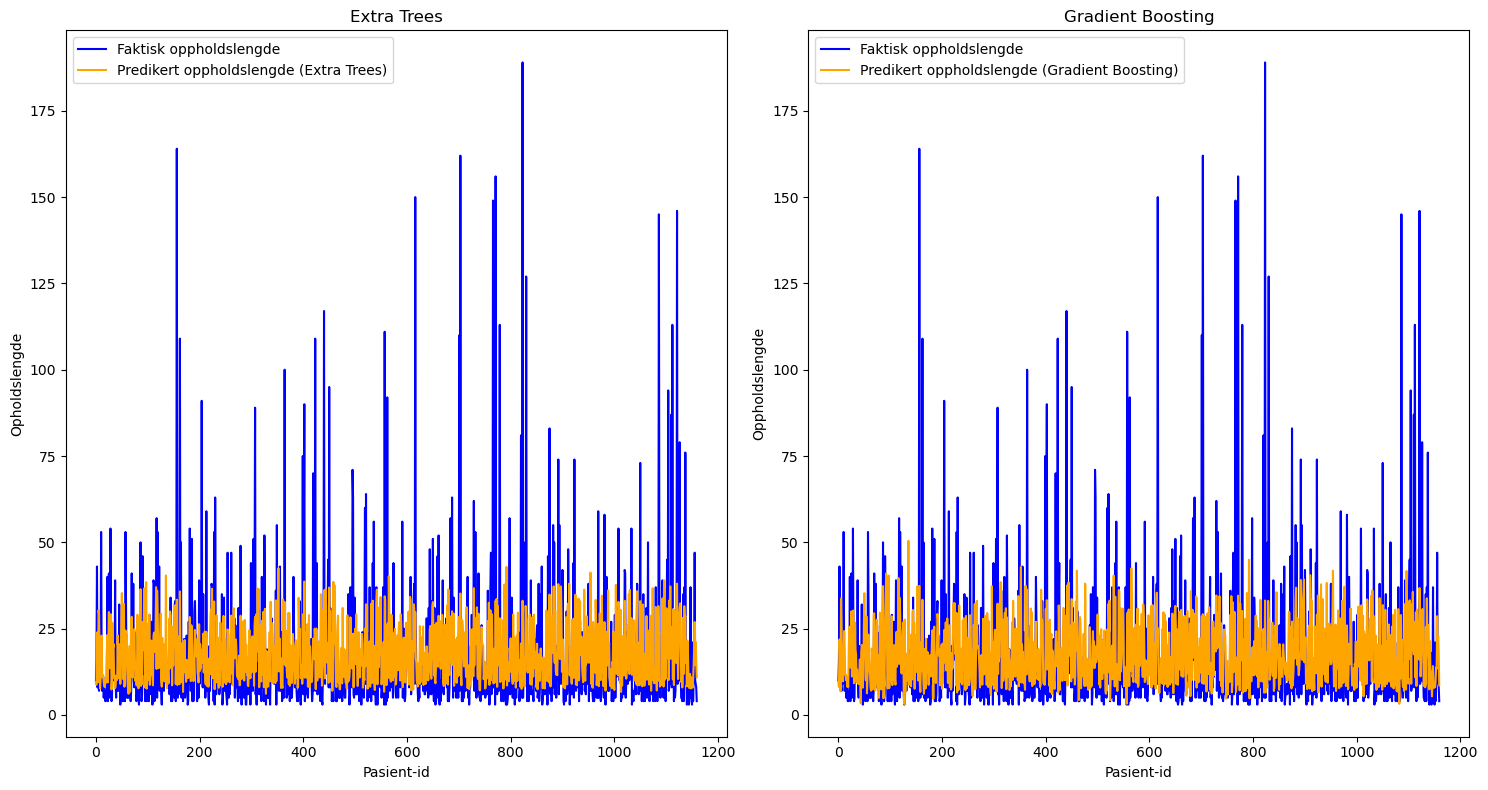

In [863]:
import matplotlib.pyplot as plt
import numpy as np

# Fit the models
extraTrees_second.fit(X_train, y_train)
gradient_second.fit(X_train, y_train)

# Predict values
y_pred_extraTrees = extraTrees_second.predict(X_val)
y_pred_gradient = gradient_second.predict(X_val)

plt.figure(figsize=(15, 8))

# Extra Trees plot
plt.subplot(1, 2, 1)
plt.plot(y_val, label='Faktisk oppholdslengde', color='blue')
plt.plot(y_pred_extraTrees, label='Predikert oppholdslengde (Extra Trees)', color='orange')
plt.title('Extra Trees')
plt.xlabel('Pasient-id')
plt.ylabel('Opholdslengde')
plt.legend()

# Gradient Boosting plot
plt.subplot(1, 2, 2)
plt.plot(y_val, label='Faktisk oppholdslengde', color='blue')
plt.plot(y_pred_gradient, label='Predikert oppholdslengde (Gradient Boosting)', color='orange')
plt.title('Gradient Boosting')
plt.xlabel('Pasient-id')
plt.ylabel('Oppholdslengde')
plt.legend()

plt.tight_layout()
plt.show()


#### 7.0.1 ExtraTree med test data. 

In [864]:
models = [extraTrees_second]
model_rmse = {} 


for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    

    model_rmse[model.__class__.__name__] = rmse

    print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}")


best_model_name = min(model_rmse, key=model_rmse.get)
best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]


print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {model_rmse[best_model_name]:.4f}")

y_test_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f"RMSE på testsettet: {test_rmse:.4f}")

ExtraTreesRegressor - RMSE: 18.5478

Beste modell basert på RMSE på valideringssettet: ExtraTreesRegressor med RMSE: 18.5478
RMSE på testsettet: 21.8419


In [865]:
X_train.columns

Index(['alder', 'inntekt', 'etnisitet', 'hvite_blodlegemer',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'blod_ph', 'glukose', 'sykdomskategori',
       'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens', 'lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'kjønn', 'utdanning_kategori',
       'fysiologisk_score_merge', 'fysiologisk_komorbiditet_mult',
       'nyrefunksjon', 'hjertefunksjon', 'kreft_sammenslått'],
      dtype='object')

In [866]:
X_train.columns

Index(['alder', 'inntekt', 'etnisitet', 'hvite_blodlegemer',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'blod_ph', 'glukose', 'sykdomskategori',
       'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens', 'lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'kjønn', 'utdanning_kategori',
       'fysiologisk_score_merge', 'fysiologisk_komorbiditet_mult',
       'nyrefunksjon', 'hjertefunksjon', 'kreft_sammenslått'],
      dtype='object')

#### Lagrer til nettside

In [867]:
import pickle


with open('model.pkl', 'wb') as model_file:
    pickle.dump(extraTrees_second, model_file)

model = pickle.load(open('model.pkl', 'rb'))


In [868]:
print(X_train['serumalbumin'].mean())

2.967384686429337


In [869]:
X_train['sykdomskategori'].value_counts()


sykdomskategori
1.0    2536
2.0    1655
4.0     849
3.0     373
Name: count, dtype: int64

In [870]:
X_train['fysiologisk_score_merge'].mean()

np.float64(31.581263107611306)

In [871]:
X_train['serumalbumin'].mean()

np.float64(2.967384686429337)

In [872]:
X_train['hvite_blodlegemer'].mean()

np.float64(12.37319256597868)

In [873]:
X_train['nyrefunksjon'].mean()

np.float64(53.09948565819012)

In [874]:
X_train['hjertefunksjon'].mean()

np.float64(90.95275263255127)

In [875]:
X_train['respirasjonsfrekvens'].mean()

np.float64(23.48291150932939)

In [876]:
X_train['lege_overlevelsesestimat_2mnd'].mean()

np.float64(0.6189440784840422)

In [880]:
X_train['adl_stedfortreder'].value()

AttributeError: 'Series' object has no attribute 'value'

In [886]:
X_train['fysiologisk_score_merge'].max()


np.float64(119.5)

In [890]:
X_train['nyrefunksjon'].describe()


count    5413.000000
mean       53.099486
std         8.258117
min        39.269996
25%        48.103309
50%        50.170000
75%        54.833333
max       103.533285
Name: nyrefunksjon, dtype: float64

In [891]:
X_train['hjertefunksjon'].describe()


count    5413.000000
mean       90.952753
std        21.622030
min         0.000000
25%        77.500000
50%        90.000000
75%       103.500000
max       187.500000
Name: hjertefunksjon, dtype: float64

In [892]:
X_train['respirasjonsfrekvens'].describe()


count    5413.000000
mean       23.482912
std         9.639604
min         0.000000
25%        18.000000
50%        24.000000
75%        28.000000
max        90.000000
Name: respirasjonsfrekvens, dtype: float64